In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-28 22:33:48.815129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging'
background = 50
photons_per_pixel = 400
patch_size = 78
sample = 'full_volume_lung'

single_lens_data = np.load(os.path.join(data_path, 'full_volume_lung_single_lens.npy'))
double_lens_data = np.load(os.path.join(data_path, 'full_volume_lung_double_lens.npy'))
many_lens_data = np.load(os.path.join(data_path, 'full_volume_lung_many_lens.npy'))

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())

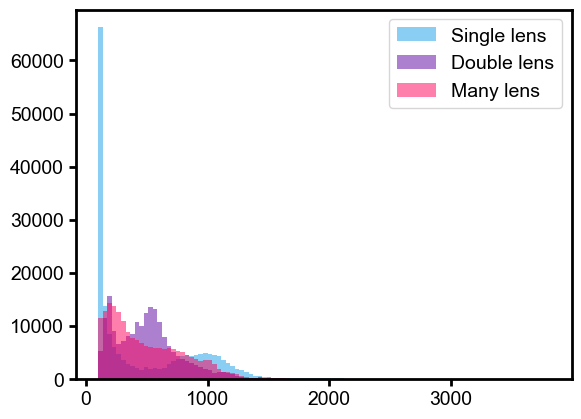

In [8]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

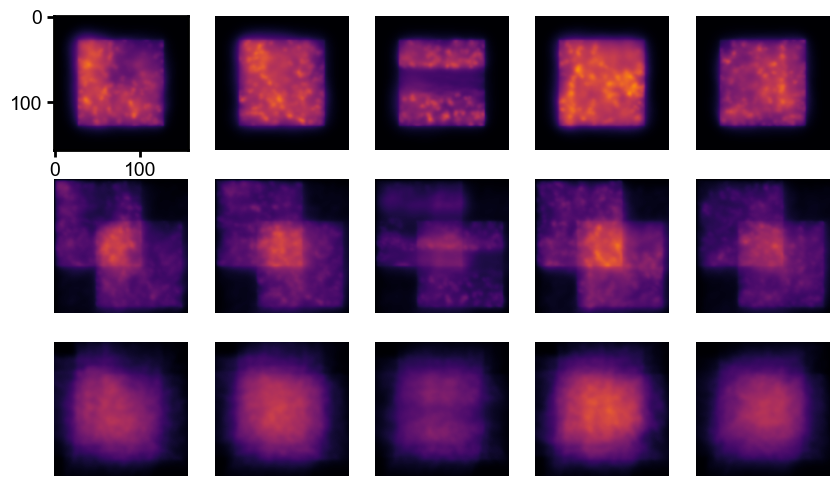

In [4]:
vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

In [36]:
# # Try nearest neighbor distance
# from encoding_information.information_estimation import *

# single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
# double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
# many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)


# @partial(jit, static_argnums=1)
# def nearest_neighbors_distance(X, k):
#     """
#     Compute the distance to the kth nearest neighbor for each point in X by
#     exhaustively searching all points in X.
    
#     X : ndarray, shape (n_samples, W, H) or (n_samples, num_features)
#     k : int
#     """
#     X = X.reshape(X.shape[0], -1)
#     distance_matrix = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
#     kth_nn_index = np.argsort(distance_matrix, axis=-1)[:, k]
#     kth_nn = X[kth_nn_index, :]
#     kth_nn_dist = np.sum(np.abs(X - kth_nn), axis=-1)
#     # kth_nn_dist = np.sqrt(np.sum((X - kth_nn)**2, axis=-1))
#     return kth_nn_dist


# k = 1000
# print(nearest_neighbors_distance(single_lens_patches, k).mean(),
#         nearest_neighbors_distance(double_lens_patches, k).mean(), 
#         nearest_neighbors_distance(many_lens_patches, k).mean())


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:30<00:00, 161.54it/s]


2376169.8 1694338.4 1754372.9


# Generate and train

100%|██████████| 10/10 [00:00<00:00, 142.16it/s]


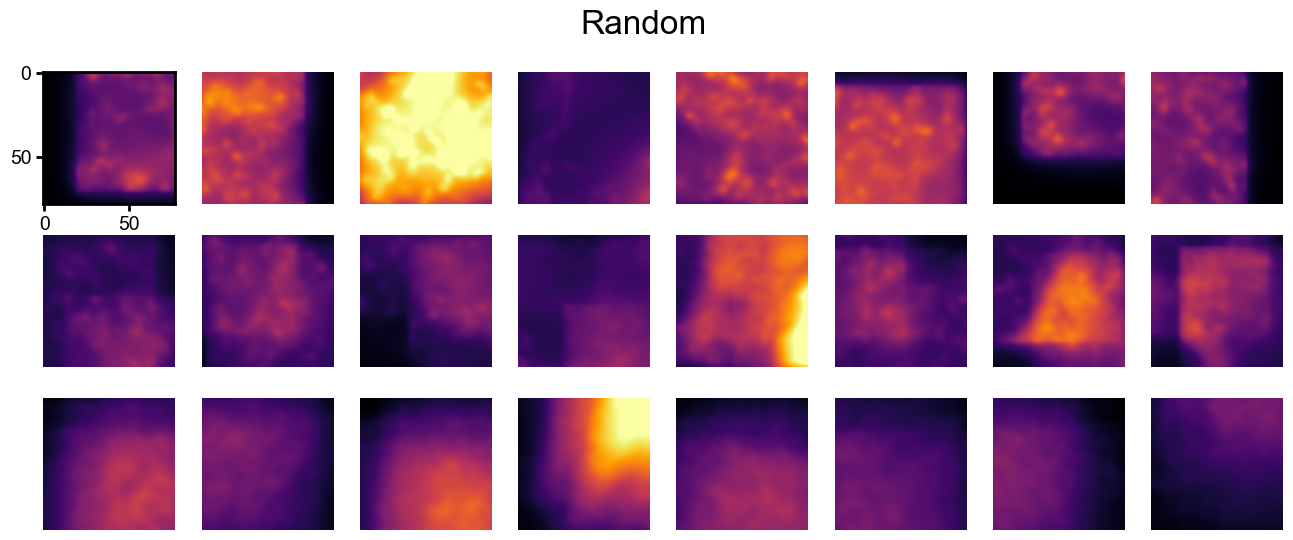

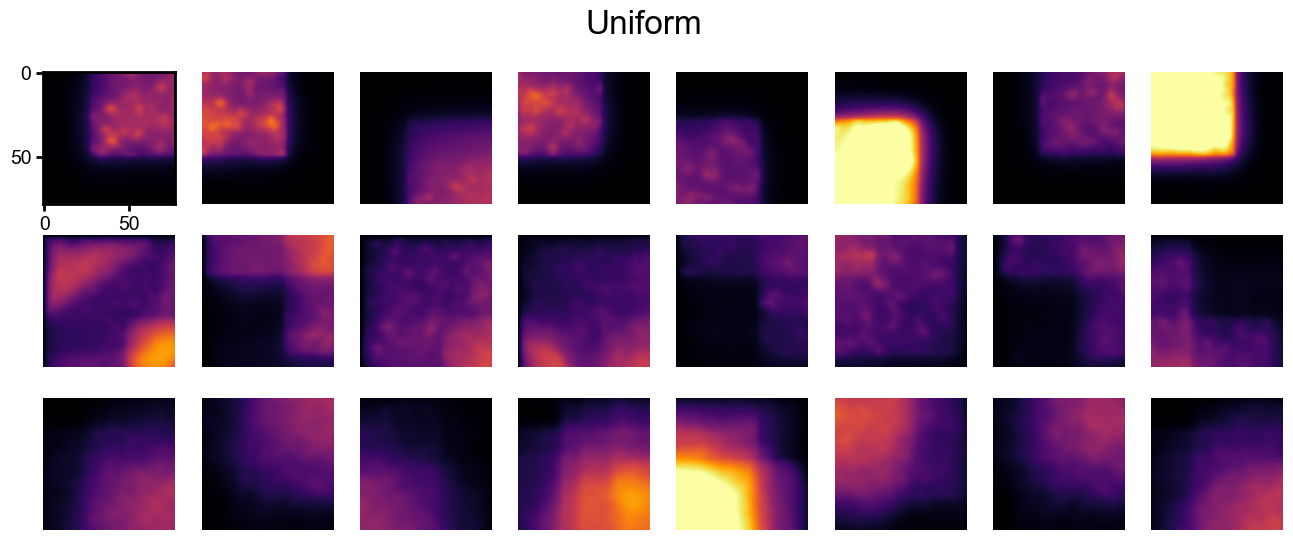

In [3]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]


vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


for uniform in [False, True]:

    if uniform:
        single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
    else:
        single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        

    fig, axs = plt.subplots(3, 8, figsize=(16, 6))

    for i in range(8):
        axs[0, i].imshow(single_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[1, i].imshow(double_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[2, i].imshow(many_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        if i != 0:
            axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[2, i].axis('off')
    fig.suptitle('Uniform' if uniform else 'Random')

In [4]:
for i in range(10):

    # single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches)
    double_lens_noisy_patches = add_noise(double_lens_patches)
    many_lens_noisy_patches = add_noise(many_lens_patches)


    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, entropy_model='pixel_cnn', verbose=True)

    # do gaussian
    single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, verbose=True)
    double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches,  verbose=True)
    many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, verbose=True)


    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path)])
        
    def save_data(data, gaussian_or_pcnn, lens):
        saving_path = [gaussian_or_pcnn, sample, lens, f'{photons_per_pixel}_photons', f'{background}_background']
        full_path = os.sep.join([data_path] + saving_path)
        # make this directory if it doesn't exist, creating intermediate directories as necessary
        os.makedirs(full_path, exist_ok=True)
        suffix = get_next_suffix(full_path)
        np.save(os.path.join(full_path, f'patch_{patch_size}_{suffix}.npy'), data)


    save_data(single_lens_mi_pcnn, 'pcnn', 'single_lens')
    save_data(double_lens_mi_pcnn, 'pcnn', 'double_lens')
    save_data(many_lens_mi_pcnn, 'pcnn', 'many_lens')

    save_data(single_lens_mi_gaussian, 'gaussian', 'single_lens')
    save_data(double_lens_mi_gaussian, 'gaussian', 'double_lens')
    save_data(many_lens_mi_gaussian, 'gaussian', 'many_lens')

2024-01-28 22:35:23.675493: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Initial validation NLL: 439.04


Epoch 1: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Epoch 1: validation NLL: 5.92


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 2: validation NLL: 6.05


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 3: validation NLL: 5.73


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 4: validation NLL: 6.41


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 5: validation NLL: 5.93


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 6: validation NLL: 6.72


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 7: validation NLL: 6.01


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 8: validation NLL: 7.24


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 9: validation NLL: 7.21


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 10: validation NLL: 7.20


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 11: validation NLL: 7.20


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 12: validation NLL: 7.19


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 13: validation NLL: 7.19


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 14: validation NLL: 7.19


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 15: validation NLL: 7.18


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 16: validation NLL: 7.17


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 17: validation NLL: 7.21


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 18: validation NLL: 7.21


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 19: validation NLL: 7.21


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 20: validation NLL: 7.20


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 21: validation NLL: 7.20


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 22: validation NLL: 7.20


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 23: validation NLL: 7.20


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 24: validation NLL: 7.20


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 25: validation NLL: 7.20


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 26: validation NLL: 7.20


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 27: validation NLL: 7.20


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 28: validation NLL: 7.20


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 29: validation NLL: 7.20


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 30: validation NLL: 7.20


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 31: validation NLL: 7.20


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 32: validation NLL: 7.20


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 33: validation NLL: 7.20


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 34: validation NLL: 7.20


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 35: validation NLL: 7.20


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 36: validation NLL: 7.20


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 37: validation NLL: 7.20


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 38: validation NLL: 7.20


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 39: validation NLL: 7.20


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 40: validation NLL: 7.20


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 41: validation NLL: 7.20


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 42: validation NLL: 7.20


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 43: validation NLL: 7.20
Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.723 differential entropy/pixel
Estimated I(Y;X) = 2.296 bits/pixel
Initial validation NLL: 328.20


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


Epoch 1: validation NLL: 5.91


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 2: validation NLL: 5.14


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 3: validation NLL: 4.86


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 4: validation NLL: 5.61


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 6: validation NLL: 6.40


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 7: validation NLL: 5.31


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 8: validation NLL: 5.05


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 10: validation NLL: 4.67


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 11: validation NLL: 4.82


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 14: validation NLL: 4.63


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 16: validation NLL: 4.51


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 17: validation NLL: 4.51


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 18: validation NLL: 4.56


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 19: validation NLL: 4.73


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 20: validation NLL: 4.50


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 21: validation NLL: 4.92


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 22: validation NLL: 4.77


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 23: validation NLL: 5.13


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 24: validation NLL: 4.56


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 27: validation NLL: 4.51


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 28: validation NLL: 4.51


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 29: validation NLL: 5.35


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 30: validation NLL: 4.71


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 31: validation NLL: 4.70


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 32: validation NLL: 4.52


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 33: validation NLL: 4.65


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 34: validation NLL: 4.57


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 35: validation NLL: 4.54


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 36: validation NLL: 4.51


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 37: validation NLL: 4.54


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 38: validation NLL: 4.50


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 39: validation NLL: 4.52


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 40: validation NLL: 4.49


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 41: validation NLL: 4.57


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 42: validation NLL: 4.50


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 43: validation NLL: 4.69


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 45: validation NLL: 4.48


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 46: validation NLL: 4.50


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 47: validation NLL: 4.53


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 48: validation NLL: 5.77


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 49: validation NLL: 6.72


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 50: validation NLL: 6.68


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 51: validation NLL: 6.84


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 52: validation NLL: 6.72


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 53: validation NLL: 6.70


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 54: validation NLL: 6.70


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 55: validation NLL: 6.70


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 56: validation NLL: 6.69


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 57: validation NLL: 6.72


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 58: validation NLL: 6.70


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 59: validation NLL: 6.70


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 60: validation NLL: 6.70


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 61: validation NLL: 6.70


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 62: validation NLL: 6.70


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 63: validation NLL: 6.70


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 64: validation NLL: 6.70


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 65: validation NLL: 6.70


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 66: validation NLL: 6.70


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 67: validation NLL: 6.70


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 68: validation NLL: 6.70


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 69: validation NLL: 6.70


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 70: validation NLL: 6.70


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 71: validation NLL: 6.70


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 72: validation NLL: 6.70


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 73: validation NLL: 6.70


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 74: validation NLL: 6.70


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 75: validation NLL: 6.70


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 76: validation NLL: 6.70


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 77: validation NLL: 6.70


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 78: validation NLL: 6.70


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 79: validation NLL: 6.70


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 80: validation NLL: 6.70


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 81: validation NLL: 6.70


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 82: validation NLL: 6.70


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 83: validation NLL: 6.70


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 84: validation NLL: 6.70


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 85: validation NLL: 6.69
Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.509 differential entropy/pixel
Estimated I(Y;X) = 0.236 bits/pixel
Initial validation NLL: 340.59


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 1: validation NLL: 6.05


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 2: validation NLL: 5.72


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 3: validation NLL: 4.73


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 4: validation NLL: 4.97


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 5: validation NLL: 5.29


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 6: validation NLL: 4.70


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 7: validation NLL: 4.65


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 8: validation NLL: 4.65


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 9: validation NLL: 4.52


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 10: validation NLL: 4.70


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 11: validation NLL: 4.53


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 12: validation NLL: 4.84


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 13: validation NLL: 4.90


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 14: validation NLL: 4.85


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 15: validation NLL: 4.73


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 16: validation NLL: 5.15


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 17: validation NLL: 5.29


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 18: validation NLL: 4.69


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 19: validation NLL: 4.45


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 20: validation NLL: 4.43


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 21: validation NLL: 4.49


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 22: validation NLL: 4.42


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 23: validation NLL: 4.62


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 24: validation NLL: 4.48


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 25: validation NLL: 4.45


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 27: validation NLL: 4.44


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 28: validation NLL: 4.43


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 29: validation NLL: 4.43


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 30: validation NLL: 4.43


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 31: validation NLL: 4.45


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 32: validation NLL: 5.17


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 33: validation NLL: 4.68


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 34: validation NLL: 4.48


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 35: validation NLL: 4.44


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 36: validation NLL: 4.41


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 37: validation NLL: 4.46


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 38: validation NLL: 4.47


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 39: validation NLL: 4.40


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 40: validation NLL: 4.40


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 41: validation NLL: 4.42


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 42: validation NLL: 4.47


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 43: validation NLL: 4.55


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 44: validation NLL: 4.41


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 45: validation NLL: 4.39


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 46: validation NLL: 4.49


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 47: validation NLL: 4.43


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 48: validation NLL: 4.39


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 49: validation NLL: 4.41


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 50: validation NLL: 4.40


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 51: validation NLL: 4.51


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 52: validation NLL: 4.42


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 53: validation NLL: 5.55


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 54: validation NLL: 6.60


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 55: validation NLL: 5.51


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 56: validation NLL: 6.87


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 57: validation NLL: 6.87


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 58: validation NLL: 6.87


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 59: validation NLL: 6.87


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 60: validation NLL: 6.87


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 61: validation NLL: 6.87


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 62: validation NLL: 6.87


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 63: validation NLL: 6.87


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 64: validation NLL: 6.87


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 65: validation NLL: 6.87


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 66: validation NLL: 6.87


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 67: validation NLL: 6.87


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 68: validation NLL: 6.87


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 69: validation NLL: 6.87


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 70: validation NLL: 6.87


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 71: validation NLL: 6.87


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 72: validation NLL: 6.87


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 73: validation NLL: 6.87


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 74: validation NLL: 6.87


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 75: validation NLL: 6.87


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 76: validation NLL: 6.87


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 77: validation NLL: 6.87


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 78: validation NLL: 6.87


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 79: validation NLL: 6.87


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 80: validation NLL: 6.87


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 81: validation NLL: 6.87


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 82: validation NLL: 6.87


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 83: validation NLL: 6.87


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 84: validation NLL: 6.87


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 85: validation NLL: 6.87


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 86: validation NLL: 6.87


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 87: validation NLL: 6.87


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 88: validation NLL: 6.87
Estimated H(Y|X) = 4.308 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.403 differential entropy/pixel
Estimated I(Y;X) = 0.137 bits/pixel


2024-01-28 23:38:00.326147: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-01-28 23:38:28.543845: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m28.21778378s

********************************
[Compiling module jit_average_diagonals_to_make_doubly_toeplitz] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  wa

trying eigenvalue floor of 0.01


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.1


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.1
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 1.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 10.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 10.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 100.0
Initial validation NLL: 106.28


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]2024-01-28 23:44:38.284270: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m22.990628042s

********************************
[Compiling module jit__train_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch 1: 100%|██████████| 1/1 [06:09<00:00, 369.32s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:237: UserWarning: NaN encountered in validation loss. Stopping early.
  warnings.warn('NaN encountered in validation loss. Stopping early.')
precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 35.82it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 43.42it/s]


Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 105.516 differential entropy/pixel
Estimated I(Y;X) = 146.268 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.01


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.1


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.1
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 1.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 10.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 10.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 100.0
Initial validation NLL: 19.58


Epoch 1: 100%|██████████| 1/1 [04:08<00:00, 248.49s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:237: UserWarning: NaN encountered in validation loss. Stopping early.
  warnings.warn('NaN encountered in validation loss. Stopping early.')
precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 40.93it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 40.68it/s]


Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 17.305 differential entropy/pixel
Estimated I(Y;X) = 18.697 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 36.08


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 50.39it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 40.73it/s]


Estimated H(Y|X) = 4.308 differential entropy/pixel
Estimated H(Y) (Upper bound) = 37.548 differential entropy/pixel
Estimated I(Y;X) = 47.954 bits/pixel
Initial validation NLL: 405.92


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Epoch 1: validation NLL: 6.44


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 2: validation NLL: 6.26


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 3: validation NLL: 6.20


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 4: validation NLL: 5.61


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 5: validation NLL: 5.42


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 5.17


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 8: validation NLL: 4.91


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 9: validation NLL: 4.37


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 10: validation NLL: 4.50


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 11: validation NLL: 4.43


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 12: validation NLL: 4.30


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 13: validation NLL: 4.34


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 14: validation NLL: 4.31


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 15: validation NLL: 4.42


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 16: validation NLL: 4.31


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 17: validation NLL: 4.28


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 18: validation NLL: 4.30


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 19: validation NLL: 4.31


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 20: validation NLL: 4.35


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 21: validation NLL: 4.30


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 22: validation NLL: 4.26


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 23: validation NLL: 4.34


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 24: validation NLL: 4.30


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 25: validation NLL: 4.26


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 26: validation NLL: 4.26


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 27: validation NLL: 4.28


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 28: validation NLL: 4.28


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 29: validation NLL: 4.36


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 30: validation NLL: 4.30


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 31: validation NLL: 4.27


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 32: validation NLL: 4.33


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 33: validation NLL: 4.28


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 34: validation NLL: 4.39


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 35: validation NLL: 4.25


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 36: validation NLL: 4.26


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 37: validation NLL: 4.92


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 38: validation NLL: 4.28


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.31


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 40: validation NLL: 4.26


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 41: validation NLL: 4.27


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 42: validation NLL: 4.28


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 43: validation NLL: 4.28


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 44: validation NLL: 4.28


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 45: validation NLL: 4.26


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 46: validation NLL: 4.24


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 47: validation NLL: 4.28


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 48: validation NLL: 4.31


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 49: validation NLL: 4.25


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 50: validation NLL: 4.27


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 51: validation NLL: 4.24


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 52: validation NLL: 4.24


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 53: validation NLL: 4.25


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 54: validation NLL: 4.26


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 55: validation NLL: 4.34


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 56: validation NLL: 5.41


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 57: validation NLL: 7.17


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 58: validation NLL: 7.15


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 59: validation NLL: 7.15


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 60: validation NLL: 7.15


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 61: validation NLL: 7.14


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 62: validation NLL: 7.14


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 63: validation NLL: 7.14


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 64: validation NLL: 7.14


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 65: validation NLL: 7.14


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 66: validation NLL: 7.14


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 67: validation NLL: 7.14


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 68: validation NLL: 7.14


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 69: validation NLL: 7.14


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 70: validation NLL: 7.14


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 71: validation NLL: 7.14


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 72: validation NLL: 7.14


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 73: validation NLL: 7.14


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 74: validation NLL: 7.14


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 75: validation NLL: 7.14


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 76: validation NLL: 7.14


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 77: validation NLL: 7.14


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 78: validation NLL: 7.14


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 79: validation NLL: 7.14


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 80: validation NLL: 7.14


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 81: validation NLL: 7.14


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 82: validation NLL: 7.14


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 83: validation NLL: 7.14


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 84: validation NLL: 7.14


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 85: validation NLL: 7.14


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 86: validation NLL: 7.14


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 87: validation NLL: 7.14


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 88: validation NLL: 7.14


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 89: validation NLL: 7.14


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 90: validation NLL: 7.14


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 91: validation NLL: 7.14
Estimated H(Y|X) = 4.130 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.244 differential entropy/pixel
Estimated I(Y;X) = 0.165 bits/pixel
Initial validation NLL: 294.87


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Epoch 1: validation NLL: 5.61


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 2: validation NLL: 5.20


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 3: validation NLL: 5.20


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 4: validation NLL: 4.91


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 5: validation NLL: 5.25


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 6: validation NLL: 4.96


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 7: validation NLL: 4.73


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 8: validation NLL: 4.67


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 9: validation NLL: 4.67


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 11: validation NLL: 4.53


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 12: validation NLL: 4.68


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 14: validation NLL: 4.56


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 15: validation NLL: 4.51


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 16: validation NLL: 4.49


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 17: validation NLL: 4.62


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 18: validation NLL: 4.65


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 19: validation NLL: 4.55


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 21: validation NLL: 4.52


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 22: validation NLL: 4.55


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 23: validation NLL: 4.50


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 24: validation NLL: 4.49


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 25: validation NLL: 4.54


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 27: validation NLL: 4.49


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 28: validation NLL: 4.47


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 29: validation NLL: 4.49


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 30: validation NLL: 4.49


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 31: validation NLL: 4.51


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 32: validation NLL: 4.50


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 33: validation NLL: 4.49


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 34: validation NLL: 4.49


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 35: validation NLL: 4.52


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 36: validation NLL: 4.48


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 37: validation NLL: 4.50


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 38: validation NLL: 4.58


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 39: validation NLL: 4.48


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 40: validation NLL: 4.52


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 41: validation NLL: 4.51


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 42: validation NLL: 4.48


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 43: validation NLL: 4.49


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 45: validation NLL: 4.51


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 46: validation NLL: 4.47


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 47: validation NLL: 4.50


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 48: validation NLL: 4.50


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 49: validation NLL: 4.50


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 50: validation NLL: 4.50


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 51: validation NLL: 4.51


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 52: validation NLL: 4.47


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 53: validation NLL: 4.47


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 54: validation NLL: 4.46


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 55: validation NLL: 4.48


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 56: validation NLL: 4.47


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 57: validation NLL: 4.47


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 58: validation NLL: 4.49


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 59: validation NLL: 4.47


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 60: validation NLL: 4.48


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 61: validation NLL: 4.46


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 62: validation NLL: 4.48


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 63: validation NLL: 4.46


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 64: validation NLL: 4.78


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 65: validation NLL: 4.46


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 66: validation NLL: 4.46


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 67: validation NLL: 4.46


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 68: validation NLL: 4.46


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 69: validation NLL: 4.46


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 70: validation NLL: 4.49


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 71: validation NLL: 4.50


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 72: validation NLL: 4.48


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 73: validation NLL: 4.56


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 74: validation NLL: 4.46


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 75: validation NLL: 4.48


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 76: validation NLL: 4.73


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 77: validation NLL: 5.73


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 78: validation NLL: 5.18


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 79: validation NLL: 4.65


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 80: validation NLL: 4.65


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 81: validation NLL: 4.66


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 82: validation NLL: 4.54


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 83: validation NLL: 4.62


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 84: validation NLL: 4.52


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 85: validation NLL: 4.59


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 86: validation NLL: 4.54


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 87: validation NLL: 4.57


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 88: validation NLL: 4.54


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 89: validation NLL: 4.55


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 90: validation NLL: 4.51


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 91: validation NLL: 4.50


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 92: validation NLL: 4.49


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 93: validation NLL: 4.51


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 94: validation NLL: 4.48


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 95: validation NLL: 4.49


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 96: validation NLL: 4.51


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 97: validation NLL: 4.49


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 98: validation NLL: 4.64


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 99: validation NLL: 4.50


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 100: validation NLL: 4.75


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 101: validation NLL: 4.53


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 102: validation NLL: 4.49


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 103: validation NLL: 4.48


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 104: validation NLL: 4.50


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 105: validation NLL: 4.48


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 106: validation NLL: 4.50


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 107: validation NLL: 4.48
Estimated H(Y|X) = 4.347 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.450 differential entropy/pixel
Estimated I(Y;X) = 0.148 bits/pixel
Initial validation NLL: 323.10


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Epoch 1: validation NLL: 5.75


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 2: validation NLL: 5.60


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 3: validation NLL: 5.06


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 4: validation NLL: 4.76


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 6.13


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 5.57


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 5.01


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 6.90


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 4.66


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 10: validation NLL: 4.72


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.64


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 13: validation NLL: 5.11


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 15: validation NLL: 4.86


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 16: validation NLL: 4.75


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 17: validation NLL: 4.57


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 19: validation NLL: 4.47


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 20: validation NLL: 4.64


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 21: validation NLL: 4.51


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 22: validation NLL: 5.02


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 23: validation NLL: 4.52


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 24: validation NLL: 4.59


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 25: validation NLL: 4.47


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 26: validation NLL: 4.60


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 27: validation NLL: 4.54


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 28: validation NLL: 4.55


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 30: validation NLL: 4.42


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 31: validation NLL: 4.44


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 32: validation NLL: 4.76


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 33: validation NLL: 4.47


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 34: validation NLL: 4.48


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 35: validation NLL: 4.42


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 36: validation NLL: 4.44


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 37: validation NLL: 4.98


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 38: validation NLL: 4.72


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 40: validation NLL: 4.54


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 41: validation NLL: 4.41


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 42: validation NLL: 4.42


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 43: validation NLL: 4.41


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 44: validation NLL: 4.86


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 45: validation NLL: 4.49


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 46: validation NLL: 4.45


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 47: validation NLL: 4.41


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 49: validation NLL: 4.56


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 50: validation NLL: 4.52


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 51: validation NLL: 4.46


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 52: validation NLL: 4.53


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 53: validation NLL: 4.70


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 54: validation NLL: 4.75


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 55: validation NLL: 4.53


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 56: validation NLL: 4.44


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 57: validation NLL: 4.43


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 58: validation NLL: 4.46


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 59: validation NLL: 4.41


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 60: validation NLL: 4.83


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 61: validation NLL: 4.62


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 63: validation NLL: 4.41


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 64: validation NLL: 4.50


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 65: validation NLL: 4.41


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 66: validation NLL: 4.45


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 67: validation NLL: 4.91


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 68: validation NLL: 5.99


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 69: validation NLL: 6.17


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 70: validation NLL: 6.83


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 71: validation NLL: 6.83


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 72: validation NLL: 6.83


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 73: validation NLL: 6.83


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 74: validation NLL: 6.83


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 75: validation NLL: 6.82


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 76: validation NLL: 6.82


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 77: validation NLL: 6.82


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 78: validation NLL: 6.82


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 79: validation NLL: 6.82


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 80: validation NLL: 6.82


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 81: validation NLL: 6.82


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 82: validation NLL: 6.82


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 83: validation NLL: 6.82


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 84: validation NLL: 6.82


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 85: validation NLL: 6.82


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 86: validation NLL: 6.82


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 87: validation NLL: 6.82


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 88: validation NLL: 6.82


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 89: validation NLL: 6.82


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 90: validation NLL: 6.82


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 91: validation NLL: 6.82


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 92: validation NLL: 6.82


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 93: validation NLL: 6.82


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 94: validation NLL: 6.82


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 95: validation NLL: 6.82


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 96: validation NLL: 6.82


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 97: validation NLL: 6.82


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 98: validation NLL: 6.82


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 99: validation NLL: 6.82


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 100: validation NLL: 6.82


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 101: validation NLL: 6.82


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 102: validation NLL: 6.82


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 103: validation NLL: 6.82


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 104: validation NLL: 6.82


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 105: validation NLL: 6.82
Estimated H(Y|X) = 4.308 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.413 differential entropy/pixel
Estimated I(Y;X) = 0.151 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 104.17


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 40.47it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 38.93it/s]


Estimated H(Y|X) = 4.130 differential entropy/pixel
Estimated H(Y) (Upper bound) = 104.550 differential entropy/pixel
Estimated I(Y;X) = 144.876 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 18.83


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 43.57it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 44.13it/s]


Estimated H(Y|X) = 4.347 differential entropy/pixel
Estimated H(Y) (Upper bound) = 17.661 differential entropy/pixel
Estimated I(Y;X) = 19.208 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 33.27


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 43.52it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 38.59it/s]


Estimated H(Y|X) = 4.308 differential entropy/pixel
Estimated H(Y) (Upper bound) = 36.339 differential entropy/pixel
Estimated I(Y;X) = 46.212 bits/pixel
Initial validation NLL: 405.20


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Epoch 1: validation NLL: 5.92


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 2: validation NLL: 6.20


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 3: validation NLL: 5.72


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 4: validation NLL: 5.66


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 5: validation NLL: 5.42


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 4.95


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 6.13


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 8: validation NLL: 5.45


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 7.18


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 10: validation NLL: 5.99


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 11: validation NLL: 5.85


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 12: validation NLL: 7.20


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 13: validation NLL: 7.19


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 14: validation NLL: 7.19


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 15: validation NLL: 7.19


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 16: validation NLL: 7.18


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 17: validation NLL: 7.18


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 18: validation NLL: 7.18


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 19: validation NLL: 7.18


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 20: validation NLL: 7.18


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 21: validation NLL: 7.18


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 22: validation NLL: 7.18


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 23: validation NLL: 7.18


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 24: validation NLL: 7.18


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 25: validation NLL: 7.18


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 26: validation NLL: 7.18


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 27: validation NLL: 7.18


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 28: validation NLL: 7.18


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 29: validation NLL: 7.18


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 30: validation NLL: 7.18


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 31: validation NLL: 7.18


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 32: validation NLL: 7.18


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 33: validation NLL: 7.18


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 34: validation NLL: 7.18


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 35: validation NLL: 7.18


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 36: validation NLL: 7.18


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 37: validation NLL: 7.18


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 38: validation NLL: 7.18


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 39: validation NLL: 7.18


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 40: validation NLL: 7.18


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 41: validation NLL: 7.18


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 42: validation NLL: 7.18


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 43: validation NLL: 7.18


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 44: validation NLL: 7.18


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 45: validation NLL: 7.18


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 46: validation NLL: 7.17
Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.986 differential entropy/pixel
Estimated I(Y;X) = 1.233 bits/pixel
Initial validation NLL: 338.00


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Epoch 1: validation NLL: 5.74


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 2: validation NLL: 5.64


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 3: validation NLL: 4.88


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 4: validation NLL: 4.66


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 4.67


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 6: validation NLL: 5.04


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 7: validation NLL: 5.15


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 5.14


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 9: validation NLL: 4.93


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 10: validation NLL: 4.96


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 12: validation NLL: 4.88


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 14: validation NLL: 4.73


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 15: validation NLL: 4.68


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 16: validation NLL: 4.65


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 17: validation NLL: 4.66


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 18: validation NLL: 4.56


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 19: validation NLL: 4.57


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 20: validation NLL: 4.60


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 21: validation NLL: 4.68


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 23: validation NLL: 4.53


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 24: validation NLL: 5.12


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 25: validation NLL: 5.22


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 26: validation NLL: 4.56


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 27: validation NLL: 4.55


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 30: validation NLL: 4.52


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 31: validation NLL: 4.54


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 32: validation NLL: 4.61


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 33: validation NLL: 4.62


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 34: validation NLL: 4.59


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 35: validation NLL: 4.53


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 36: validation NLL: 4.76


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 37: validation NLL: 4.53


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 38: validation NLL: 4.58


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.52


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 40: validation NLL: 4.65


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 41: validation NLL: 4.57


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 42: validation NLL: 4.61


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 43: validation NLL: 4.56


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 44: validation NLL: 4.57


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 45: validation NLL: 4.54


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 46: validation NLL: 4.53


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 47: validation NLL: 4.50


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 48: validation NLL: 4.54


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 49: validation NLL: 4.72


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 50: validation NLL: 4.58


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 51: validation NLL: 4.56


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 52: validation NLL: 4.52


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 53: validation NLL: 4.61


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 54: validation NLL: 4.53


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 55: validation NLL: 4.61


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 56: validation NLL: 5.26


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 6.10


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 58: validation NLL: 6.31


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 59: validation NLL: 5.23


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 60: validation NLL: 4.90


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 61: validation NLL: 4.82


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 62: validation NLL: 4.63


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 63: validation NLL: 4.63


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 64: validation NLL: 4.63


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 65: validation NLL: 4.57


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 66: validation NLL: 4.58


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 67: validation NLL: 4.55


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 68: validation NLL: 4.59


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 69: validation NLL: 4.55


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 70: validation NLL: 4.55


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 71: validation NLL: 4.53


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 72: validation NLL: 4.58


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 73: validation NLL: 4.53


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 74: validation NLL: 4.52


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 75: validation NLL: 4.52


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 76: validation NLL: 4.59


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 77: validation NLL: 4.56


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 78: validation NLL: 4.54


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 79: validation NLL: 4.54


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 80: validation NLL: 4.54


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 81: validation NLL: 4.51


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 82: validation NLL: 4.53


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 83: validation NLL: 4.54


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 84: validation NLL: 4.53


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 85: validation NLL: 4.50


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 86: validation NLL: 4.51


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 87: validation NLL: 4.51
Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.497 differential entropy/pixel
Estimated I(Y;X) = 0.217 bits/pixel
Initial validation NLL: 343.76


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Epoch 1: validation NLL: 6.12


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 2: validation NLL: 5.71


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 3: validation NLL: 6.05


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 4: validation NLL: 5.49


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 5: validation NLL: 4.95


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 6: validation NLL: 4.87


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 7: validation NLL: 4.93


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 5.24


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 4.70


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 10: validation NLL: 4.65


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.57


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 13: validation NLL: 4.49


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 14: validation NLL: 4.45


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 15: validation NLL: 4.47


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 16: validation NLL: 4.47


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 17: validation NLL: 4.63


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 18: validation NLL: 4.47


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 19: validation NLL: 4.44


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 20: validation NLL: 4.45


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 21: validation NLL: 4.44


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 22: validation NLL: 4.43


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 23: validation NLL: 4.42


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 25: validation NLL: 4.44


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 26: validation NLL: 4.44


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 27: validation NLL: 4.44


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 28: validation NLL: 4.42


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 29: validation NLL: 4.54


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 30: validation NLL: 4.46


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 31: validation NLL: 4.44


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 32: validation NLL: 4.42


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 33: validation NLL: 4.49


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 34: validation NLL: 4.42


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 36: validation NLL: 4.43


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 37: validation NLL: 4.41


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 38: validation NLL: 4.69


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 39: validation NLL: 4.42


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 40: validation NLL: 4.43


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 41: validation NLL: 4.45


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 42: validation NLL: 4.44


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 43: validation NLL: 4.42


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 44: validation NLL: 4.43


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 45: validation NLL: 4.42


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 46: validation NLL: 4.69


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 47: validation NLL: 4.56


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 48: validation NLL: 4.46


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 49: validation NLL: 4.42


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 50: validation NLL: 4.43


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 51: validation NLL: 4.45


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 52: validation NLL: 4.42


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 53: validation NLL: 4.45


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 54: validation NLL: 4.48


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 55: validation NLL: 4.40


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 56: validation NLL: 4.41


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 57: validation NLL: 4.43


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 58: validation NLL: 4.40


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 59: validation NLL: 4.47


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 60: validation NLL: 4.41


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 61: validation NLL: 4.41


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 62: validation NLL: 4.45


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 63: validation NLL: 4.41


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 64: validation NLL: 4.41


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 65: validation NLL: 4.45


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 66: validation NLL: 4.46


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 67: validation NLL: 4.45


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 68: validation NLL: 4.41


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 69: validation NLL: 4.40


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 70: validation NLL: 4.47


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 71: validation NLL: 4.42


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 72: validation NLL: 4.44


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 73: validation NLL: 4.41


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 74: validation NLL: 4.43


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 75: validation NLL: 4.40


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 76: validation NLL: 4.43


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 77: validation NLL: 4.57


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 78: validation NLL: 4.41


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 79: validation NLL: 4.43


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 80: validation NLL: 4.40


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 81: validation NLL: 4.40


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 82: validation NLL: 4.41


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 83: validation NLL: 4.40


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 84: validation NLL: 4.41


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 85: validation NLL: 4.47


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 86: validation NLL: 4.43


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 87: validation NLL: 4.47


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 88: validation NLL: 4.40


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 89: validation NLL: 4.41


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 90: validation NLL: 4.40


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 91: validation NLL: 4.52


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 92: validation NLL: 4.42


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 93: validation NLL: 4.52


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 94: validation NLL: 4.40


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 95: validation NLL: 4.41


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 96: validation NLL: 4.42


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 97: validation NLL: 4.41


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 98: validation NLL: 4.40


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 99: validation NLL: 4.44


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 100: validation NLL: 4.40


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 101: validation NLL: 4.41


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 102: validation NLL: 4.40


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 103: validation NLL: 4.42


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 104: validation NLL: 4.40


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 105: validation NLL: 4.47


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 106: validation NLL: 4.40


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 107: validation NLL: 4.44


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 108: validation NLL: 4.41


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 109: validation NLL: 4.41


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 110: validation NLL: 4.40


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 111: validation NLL: 4.50


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 112: validation NLL: 4.40


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 113: validation NLL: 4.41


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 114: validation NLL: 4.41


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 115: validation NLL: 4.43


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 116: validation NLL: 4.40


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 117: validation NLL: 4.40


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 118: validation NLL: 4.43


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 119: validation NLL: 4.40


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 120: validation NLL: 4.40


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 121: validation NLL: 4.40


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 122: validation NLL: 4.42


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 123: validation NLL: 4.42


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 124: validation NLL: 4.40


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 125: validation NLL: 4.45


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 126: validation NLL: 4.40


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 127: validation NLL: 4.40


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 128: validation NLL: 4.84


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 129: validation NLL: 5.94


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 130: validation NLL: 5.64


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 131: validation NLL: 6.69


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 132: validation NLL: 6.84


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 133: validation NLL: 6.83


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 134: validation NLL: 6.83


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 135: validation NLL: 6.83


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 136: validation NLL: 6.83


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 137: validation NLL: 6.83


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 138: validation NLL: 6.83


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 139: validation NLL: 6.83


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 140: validation NLL: 6.83


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 141: validation NLL: 6.83


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 142: validation NLL: 6.83


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 143: validation NLL: 6.83


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 144: validation NLL: 6.83


Epoch 145: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 145: validation NLL: 6.83


Epoch 146: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 146: validation NLL: 6.83
Estimated H(Y|X) = 4.307 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.376 differential entropy/pixel
Estimated I(Y;X) = 0.099 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 91.81


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 40.25it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 42.01it/s]


Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 92.417 differential entropy/pixel
Estimated I(Y;X) = 127.370 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 18.48


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 41.88it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 42.40it/s]


Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 17.397 differential entropy/pixel
Estimated I(Y;X) = 18.829 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 36.72


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 39.01it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 41.60it/s]


Estimated H(Y|X) = 4.307 differential entropy/pixel
Estimated H(Y) (Upper bound) = 35.323 differential entropy/pixel
Estimated I(Y;X) = 44.746 bits/pixel
Initial validation NLL: 399.68


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Epoch 1: validation NLL: 6.19


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 2: validation NLL: 6.20


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 3: validation NLL: 6.08


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 4: validation NLL: 6.39


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 5.98


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 6: validation NLL: 5.69


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 7: validation NLL: 5.23


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 4.89


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 9: validation NLL: 4.84


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 10: validation NLL: 5.34


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 11: validation NLL: 4.86


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 12: validation NLL: 4.64


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 16: validation NLL: 4.40


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 17: validation NLL: 4.41


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 18: validation NLL: 4.48


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 19: validation NLL: 4.54


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 20: validation NLL: 4.37


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 21: validation NLL: 4.46


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 22: validation NLL: 4.36


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 23: validation NLL: 4.42


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 24: validation NLL: 4.39


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 25: validation NLL: 4.38


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 27: validation NLL: 4.35


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 28: validation NLL: 4.43


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 29: validation NLL: 4.34


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 30: validation NLL: 4.38


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 31: validation NLL: 4.39


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 32: validation NLL: 4.61


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 33: validation NLL: 4.34


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 34: validation NLL: 4.41


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 35: validation NLL: 4.35


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 36: validation NLL: 4.31


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 37: validation NLL: 4.33


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 38: validation NLL: 4.34


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.33


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 40: validation NLL: 4.49


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 41: validation NLL: 4.33


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 42: validation NLL: 4.40


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 43: validation NLL: 4.31


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 44: validation NLL: 4.34


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 45: validation NLL: 4.37


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 46: validation NLL: 4.30


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 47: validation NLL: 4.31


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 48: validation NLL: 4.30


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 49: validation NLL: 4.33


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 50: validation NLL: 4.30


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 51: validation NLL: 4.34


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 52: validation NLL: 4.31


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 53: validation NLL: 4.33


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 54: validation NLL: 4.57


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 55: validation NLL: 4.35


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 56: validation NLL: 4.29


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 57: validation NLL: 4.32


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 58: validation NLL: 4.36


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 59: validation NLL: 4.34


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 60: validation NLL: 4.50


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 61: validation NLL: 4.31


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 62: validation NLL: 4.29


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 63: validation NLL: 4.30


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 64: validation NLL: 4.29


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 65: validation NLL: 4.36


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 66: validation NLL: 4.32


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 67: validation NLL: 4.28


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 68: validation NLL: 4.28


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 69: validation NLL: 4.29


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 70: validation NLL: 4.28


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 71: validation NLL: 4.29


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 72: validation NLL: 4.30


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 73: validation NLL: 4.29


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 74: validation NLL: 4.45


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 75: validation NLL: 4.27


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 76: validation NLL: 4.30


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 77: validation NLL: 4.27


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 78: validation NLL: 5.47


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 79: validation NLL: 7.13


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 80: validation NLL: 7.13


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 81: validation NLL: 7.13


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 82: validation NLL: 7.13


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 83: validation NLL: 7.13


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 84: validation NLL: 7.13


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 85: validation NLL: 7.13


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 86: validation NLL: 7.13


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 87: validation NLL: 7.13


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 88: validation NLL: 7.13


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 89: validation NLL: 7.13


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 90: validation NLL: 7.13


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 91: validation NLL: 7.13


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 92: validation NLL: 7.13


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 93: validation NLL: 7.13


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 94: validation NLL: 7.13


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 95: validation NLL: 7.13


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 96: validation NLL: 7.13


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 97: validation NLL: 7.13


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 98: validation NLL: 7.13


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 99: validation NLL: 7.13


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 100: validation NLL: 7.13


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 101: validation NLL: 7.13


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 102: validation NLL: 7.13


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 103: validation NLL: 7.13


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 104: validation NLL: 7.13


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 105: validation NLL: 7.13


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 106: validation NLL: 7.13


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 107: validation NLL: 7.13


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 108: validation NLL: 7.13


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 109: validation NLL: 7.13


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 110: validation NLL: 7.13


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 111: validation NLL: 7.13


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 112: validation NLL: 7.13


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 113: validation NLL: 7.13


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 114: validation NLL: 7.13


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 115: validation NLL: 7.13


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 116: validation NLL: 7.13


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 117: validation NLL: 7.13
Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.263 differential entropy/pixel
Estimated I(Y;X) = 0.194 bits/pixel
Initial validation NLL: 330.84


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 1: validation NLL: 5.57


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 2: validation NLL: 5.22


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 3: validation NLL: 4.92


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 4: validation NLL: 4.86


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 5.55


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 7: validation NLL: 4.67


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 8: validation NLL: 4.67


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 12: validation NLL: 4.81


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 15: validation NLL: 4.50


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 16: validation NLL: 4.50


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 17: validation NLL: 4.50


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 18: validation NLL: 4.49


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 20: validation NLL: 4.53


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 22: validation NLL: 4.53


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 23: validation NLL: 4.50


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 24: validation NLL: 4.49


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 25: validation NLL: 4.50


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 26: validation NLL: 4.49


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 27: validation NLL: 4.49


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 28: validation NLL: 4.49


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 30: validation NLL: 4.64


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 31: validation NLL: 4.50


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 32: validation NLL: 4.49


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 33: validation NLL: 4.59


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 34: validation NLL: 4.53


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 35: validation NLL: 4.47


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 37: validation NLL: 4.50


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 38: validation NLL: 4.51


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 40: validation NLL: 4.60


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 41: validation NLL: 4.50


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 42: validation NLL: 4.50


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 43: validation NLL: 4.48


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 44: validation NLL: 4.48


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 45: validation NLL: 4.51


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 46: validation NLL: 4.49


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 48: validation NLL: 4.47


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 49: validation NLL: 4.47


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 51: validation NLL: 5.40


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 52: validation NLL: 6.74


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 53: validation NLL: 6.72


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 54: validation NLL: 6.72


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 55: validation NLL: 6.72


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 56: validation NLL: 6.72


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 6.72


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 58: validation NLL: 6.72


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 59: validation NLL: 6.72


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 60: validation NLL: 6.72


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 61: validation NLL: 6.72


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 62: validation NLL: 6.72


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 63: validation NLL: 6.72


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 64: validation NLL: 6.72


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 65: validation NLL: 6.72


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 66: validation NLL: 6.72


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 67: validation NLL: 6.72


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 68: validation NLL: 6.72


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 69: validation NLL: 6.72


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 70: validation NLL: 6.72


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 71: validation NLL: 6.72


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 72: validation NLL: 6.72


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 73: validation NLL: 6.72


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 74: validation NLL: 6.72


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 75: validation NLL: 6.72


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 76: validation NLL: 6.72


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 77: validation NLL: 6.72


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 78: validation NLL: 6.72


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 79: validation NLL: 6.72


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 80: validation NLL: 6.72


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 81: validation NLL: 6.72


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 82: validation NLL: 6.72


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 83: validation NLL: 6.72


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 84: validation NLL: 6.72


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 85: validation NLL: 6.72


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 86: validation NLL: 6.72


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 87: validation NLL: 6.72


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 88: validation NLL: 6.72


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 89: validation NLL: 6.72
Estimated H(Y|X) = 4.347 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.464 differential entropy/pixel
Estimated I(Y;X) = 0.169 bits/pixel
Initial validation NLL: 340.61


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Epoch 1: validation NLL: 5.77


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 2: validation NLL: 5.57


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 3: validation NLL: 5.71


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 4: validation NLL: 5.26


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 5.06


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 4.92


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 5.45


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 8: validation NLL: 4.72


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 9: validation NLL: 8.00


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 10: validation NLL: 4.97


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.55


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 13: validation NLL: 4.50


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 14: validation NLL: 4.66


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 16: validation NLL: 4.67


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 17: validation NLL: 4.90


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 18: validation NLL: 4.45


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 19: validation NLL: 4.85


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 20: validation NLL: 4.54


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 21: validation NLL: 4.45


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 22: validation NLL: 4.54


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 23: validation NLL: 4.47


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 24: validation NLL: 4.48


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 25: validation NLL: 4.69


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 27: validation NLL: 4.65


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 28: validation NLL: 4.41


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 29: validation NLL: 4.43


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 30: validation NLL: 4.58


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 31: validation NLL: 4.89


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 32: validation NLL: 4.49


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 33: validation NLL: 4.43


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 34: validation NLL: 4.49


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 35: validation NLL: 4.41


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 36: validation NLL: 4.45


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 37: validation NLL: 4.52


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 38: validation NLL: 4.44


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 40: validation NLL: 4.46


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 41: validation NLL: 4.46


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 42: validation NLL: 4.54


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 43: validation NLL: 4.58


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 44: validation NLL: 4.47


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 45: validation NLL: 4.39


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 46: validation NLL: 4.39


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 47: validation NLL: 4.83


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 48: validation NLL: 5.35


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 49: validation NLL: 4.71


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 50: validation NLL: 4.45


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 51: validation NLL: 4.54


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 52: validation NLL: 4.53


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 53: validation NLL: 4.58


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 54: validation NLL: 4.42


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 55: validation NLL: 4.43


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 56: validation NLL: 4.43


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 4.42


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 58: validation NLL: 4.42


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 59: validation NLL: 4.45


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 60: validation NLL: 4.43


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 61: validation NLL: 4.41


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 62: validation NLL: 4.40


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 63: validation NLL: 4.41


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 64: validation NLL: 4.40


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 65: validation NLL: 4.42


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 66: validation NLL: 4.55


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 67: validation NLL: 4.41


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 68: validation NLL: 4.47


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 69: validation NLL: 4.41


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 70: validation NLL: 4.42


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 71: validation NLL: 4.42


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 72: validation NLL: 4.73


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 73: validation NLL: 4.41


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 74: validation NLL: 4.45


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 75: validation NLL: 4.41


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 76: validation NLL: 4.41


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 77: validation NLL: 4.40


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 78: validation NLL: 4.41


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 79: validation NLL: 4.40


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 80: validation NLL: 4.82


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 81: validation NLL: 6.20


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 82: validation NLL: 6.04


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 83: validation NLL: 6.29


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 84: validation NLL: 6.58


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 85: validation NLL: 6.89


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 86: validation NLL: 6.89
Estimated H(Y|X) = 4.311 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.400 differential entropy/pixel
Estimated I(Y;X) = 0.129 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 100.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1000.0
Initial validation NLL: 14.20


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 42.38it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 38.83it/s]


Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 14.526 differential entropy/pixel
Estimated I(Y;X) = 14.999 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 20.10


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 40.67it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 40.49it/s]


Estimated H(Y|X) = 4.347 differential entropy/pixel
Estimated H(Y) (Upper bound) = 18.299 differential entropy/pixel
Estimated I(Y;X) = 20.128 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 35.07


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 47.12it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 46.04it/s]


Estimated H(Y|X) = 4.311 differential entropy/pixel
Estimated H(Y) (Upper bound) = 36.763 differential entropy/pixel
Estimated I(Y;X) = 46.819 bits/pixel
Initial validation NLL: 377.45


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 1: validation NLL: 6.09


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 2: validation NLL: 5.76


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 3: validation NLL: 5.37


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 4: validation NLL: 5.81


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 5: validation NLL: 5.02


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 6: validation NLL: 4.73


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 8: validation NLL: 4.77


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 9: validation NLL: 4.51


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 11: validation NLL: 4.35


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 12: validation NLL: 4.66


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 13: validation NLL: 4.37


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 14: validation NLL: 4.34


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 15: validation NLL: 4.55


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 16: validation NLL: 4.52


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 17: validation NLL: 4.28


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 18: validation NLL: 4.30


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 19: validation NLL: 4.26


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 20: validation NLL: 4.31


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 21: validation NLL: 4.25


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 22: validation NLL: 4.25


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 23: validation NLL: 4.27


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 24: validation NLL: 4.26


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 25: validation NLL: 4.31


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 26: validation NLL: 4.39


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 27: validation NLL: 5.49


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 28: validation NLL: 5.78


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 29: validation NLL: 5.74


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 30: validation NLL: 8.03


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 31: validation NLL: 8.03


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 32: validation NLL: 8.03


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 33: validation NLL: 8.03


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 34: validation NLL: 8.03


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 35: validation NLL: 8.03


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 36: validation NLL: 8.03


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 37: validation NLL: 8.03


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 38: validation NLL: 8.03


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 39: validation NLL: 8.03


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 40: validation NLL: 8.03


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 41: validation NLL: 8.03


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 42: validation NLL: 8.03


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 43: validation NLL: 8.03


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 44: validation NLL: 8.03


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 45: validation NLL: 8.03


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 46: validation NLL: 8.03


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 47: validation NLL: 8.03


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 48: validation NLL: 8.03


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 49: validation NLL: 8.03


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 50: validation NLL: 8.03


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 51: validation NLL: 8.03


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 52: validation NLL: 8.03


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 53: validation NLL: 8.03


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 54: validation NLL: 8.03


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 55: validation NLL: 8.03


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 56: validation NLL: 8.03


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 57: validation NLL: 8.03


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 58: validation NLL: 8.03


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 59: validation NLL: 8.03


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 60: validation NLL: 8.03


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 61: validation NLL: 8.03
Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.251 differential entropy/pixel
Estimated I(Y;X) = 0.176 bits/pixel
Initial validation NLL: 311.62


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 1: validation NLL: 5.60


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 2: validation NLL: 5.16


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 3: validation NLL: 4.92


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 4: validation NLL: 4.73


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 5: validation NLL: 4.59


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 7: validation NLL: 4.55


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 8: validation NLL: 4.97


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 9: validation NLL: 4.95


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 10: validation NLL: 4.69


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 11: validation NLL: 4.92


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 12: validation NLL: 4.76


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 13: validation NLL: 4.66


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 14: validation NLL: 4.64


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 15: validation NLL: 4.63


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 16: validation NLL: 4.64


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 17: validation NLL: 4.71


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 18: validation NLL: 4.66


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 19: validation NLL: 4.56


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 20: validation NLL: 4.91


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 21: validation NLL: 4.55


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 22: validation NLL: 4.53


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 23: validation NLL: 4.71


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 24: validation NLL: 4.52


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 25: validation NLL: 4.52


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 26: validation NLL: 4.56


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 27: validation NLL: 4.56


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 28: validation NLL: 4.54


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 29: validation NLL: 4.51


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 30: validation NLL: 4.52


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 31: validation NLL: 4.55


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 32: validation NLL: 4.59


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 33: validation NLL: 4.60


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 34: validation NLL: 4.54


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 35: validation NLL: 4.51


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 36: validation NLL: 4.63


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 37: validation NLL: 4.51


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 38: validation NLL: 4.49


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 39: validation NLL: 4.60


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 40: validation NLL: 4.51


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 41: validation NLL: 4.93


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 42: validation NLL: 4.56


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 43: validation NLL: 4.52


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 44: validation NLL: 4.59


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 45: validation NLL: 4.52


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 46: validation NLL: 4.52


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 47: validation NLL: 4.54


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 51: validation NLL: 4.50


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 52: validation NLL: 4.49


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 53: validation NLL: 4.50


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 54: validation NLL: 4.48


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 55: validation NLL: 4.72


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 56: validation NLL: 4.55


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 4.57


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 58: validation NLL: 4.51


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 59: validation NLL: 4.49


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 60: validation NLL: 4.48


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 61: validation NLL: 4.49


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 62: validation NLL: 4.73


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 63: validation NLL: 6.87


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 64: validation NLL: 6.70


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 65: validation NLL: 6.70


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 66: validation NLL: 6.70


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 67: validation NLL: 6.70


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 68: validation NLL: 6.70


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 69: validation NLL: 6.70


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 70: validation NLL: 6.70


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 71: validation NLL: 6.70


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 72: validation NLL: 6.70


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 73: validation NLL: 6.70


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 74: validation NLL: 6.70


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 75: validation NLL: 6.70


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 76: validation NLL: 6.70


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 77: validation NLL: 6.70


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 78: validation NLL: 6.70


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 79: validation NLL: 6.70


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 80: validation NLL: 6.70


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 81: validation NLL: 6.70


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 82: validation NLL: 6.70


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 83: validation NLL: 6.70


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 84: validation NLL: 6.70


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 85: validation NLL: 6.70


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 86: validation NLL: 6.70


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 87: validation NLL: 6.70


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 88: validation NLL: 6.70


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 89: validation NLL: 6.70


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 90: validation NLL: 6.70


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 91: validation NLL: 6.70


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 92: validation NLL: 6.70


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 93: validation NLL: 6.70


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 94: validation NLL: 6.70
Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.487 differential entropy/pixel
Estimated I(Y;X) = 0.204 bits/pixel
Initial validation NLL: 333.47


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Epoch 1: validation NLL: 5.65


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 2: validation NLL: 5.24


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 3: validation NLL: 4.95


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 4: validation NLL: 5.11


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 5: validation NLL: 4.86


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 6: validation NLL: 4.92


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 5.00


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 5.18


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 10: validation NLL: 5.07


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 11: validation NLL: 4.63


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.63


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 13: validation NLL: 4.50


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 14: validation NLL: 4.63


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 15: validation NLL: 4.56


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 16: validation NLL: 4.56


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 17: validation NLL: 4.44


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 18: validation NLL: 4.42


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 19: validation NLL: 4.47


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 20: validation NLL: 4.46


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 21: validation NLL: 4.48


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 22: validation NLL: 4.52


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 23: validation NLL: 4.45


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 24: validation NLL: 4.41


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 25: validation NLL: 4.42


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 26: validation NLL: 4.71


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 27: validation NLL: 5.28


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 28: validation NLL: 4.92


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 30: validation NLL: 4.46


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 31: validation NLL: 4.48


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 32: validation NLL: 4.42


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 33: validation NLL: 4.78


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 34: validation NLL: 4.51


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 36: validation NLL: 4.45


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 37: validation NLL: 4.63


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 38: validation NLL: 4.42


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 39: validation NLL: 4.41


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 40: validation NLL: 4.42


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 41: validation NLL: 4.59


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 42: validation NLL: 4.43


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 43: validation NLL: 4.41


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 44: validation NLL: 4.47


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 45: validation NLL: 4.48


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 46: validation NLL: 5.09


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 47: validation NLL: 4.67


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 48: validation NLL: 4.49


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 49: validation NLL: 4.42


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 50: validation NLL: 4.42


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 51: validation NLL: 4.41


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 52: validation NLL: 4.54


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 53: validation NLL: 4.93


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 54: validation NLL: 4.41


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 55: validation NLL: 4.42


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 56: validation NLL: 4.47


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 57: validation NLL: 4.47


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 58: validation NLL: 4.41


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 59: validation NLL: 4.50


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 60: validation NLL: 4.41


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 61: validation NLL: 4.67


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 62: validation NLL: 4.50


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 63: validation NLL: 4.42


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 64: validation NLL: 4.41


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 65: validation NLL: 4.44


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 66: validation NLL: 4.61


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 67: validation NLL: 4.42


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 68: validation NLL: 4.40


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 69: validation NLL: 4.49


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 70: validation NLL: 4.64


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 71: validation NLL: 4.40


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 72: validation NLL: 4.40


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 73: validation NLL: 4.40


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 74: validation NLL: 4.49


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 75: validation NLL: 4.40


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 76: validation NLL: 4.50


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 77: validation NLL: 4.45


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 78: validation NLL: 4.40


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 79: validation NLL: 4.44


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 80: validation NLL: 4.42


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 81: validation NLL: 4.39


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 82: validation NLL: 4.41


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 83: validation NLL: 4.40


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 84: validation NLL: 4.41


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 85: validation NLL: 4.40


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 86: validation NLL: 4.44


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 87: validation NLL: 4.42


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 88: validation NLL: 4.63


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 89: validation NLL: 4.93


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 90: validation NLL: 5.73


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 91: validation NLL: 5.09


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 92: validation NLL: 5.41


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 93: validation NLL: 4.59


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 94: validation NLL: 4.58


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 95: validation NLL: 4.55


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 96: validation NLL: 4.51


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 97: validation NLL: 4.50


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 98: validation NLL: 4.50


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 99: validation NLL: 4.58


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 100: validation NLL: 4.53


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 101: validation NLL: 4.55


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 102: validation NLL: 4.47


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 103: validation NLL: 4.46


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 104: validation NLL: 4.55


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 105: validation NLL: 4.47


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 106: validation NLL: 4.45


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 107: validation NLL: 4.46


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 108: validation NLL: 4.46


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 109: validation NLL: 4.44


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 110: validation NLL: 4.45


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 111: validation NLL: 4.43


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 112: validation NLL: 4.52


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 113: validation NLL: 4.45


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 114: validation NLL: 4.47


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 115: validation NLL: 4.45


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 116: validation NLL: 4.44


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 117: validation NLL: 4.47


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 118: validation NLL: 4.45


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 119: validation NLL: 4.44


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 120: validation NLL: 4.46


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 121: validation NLL: 4.46
Estimated H(Y|X) = 4.309 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.390 differential entropy/pixel
Estimated I(Y;X) = 0.117 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 105.06


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 39.12it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 38.30it/s]


Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 103.485 differential entropy/pixel
Estimated I(Y;X) = 143.340 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 20.29


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 45.25it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 42.69it/s]


Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 19.589 differential entropy/pixel
Estimated I(Y;X) = 21.992 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 32.59


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 39.95it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 40.80it/s]


Estimated H(Y|X) = 4.309 differential entropy/pixel
Estimated H(Y) (Upper bound) = 34.082 differential entropy/pixel
Estimated I(Y;X) = 42.953 bits/pixel
Initial validation NLL: 417.50


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 1: validation NLL: 6.15


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 2: validation NLL: 6.18


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 3: validation NLL: 5.98


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 4: validation NLL: 6.23


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 5: validation NLL: 5.78


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 6: validation NLL: 5.05


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 4.82


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 4.76


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 9: validation NLL: 5.45


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 10: validation NLL: 5.51


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 11: validation NLL: 5.22


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 12: validation NLL: 5.07


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 13: validation NLL: 5.05


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 14: validation NLL: 7.09


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 15: validation NLL: 7.15


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 16: validation NLL: 7.15


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 17: validation NLL: 7.15


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 18: validation NLL: 7.14


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 19: validation NLL: 7.14


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 20: validation NLL: 7.14


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 21: validation NLL: 7.14


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 22: validation NLL: 7.14


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 23: validation NLL: 7.14


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 24: validation NLL: 7.14


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 25: validation NLL: 7.14


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 26: validation NLL: 7.14


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 27: validation NLL: 7.14


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 28: validation NLL: 7.14


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 29: validation NLL: 7.14


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 30: validation NLL: 7.14


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 31: validation NLL: 7.14


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 32: validation NLL: 7.14


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 33: validation NLL: 7.14


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 34: validation NLL: 7.14


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 35: validation NLL: 7.14


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 36: validation NLL: 7.14


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 37: validation NLL: 7.14


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 38: validation NLL: 7.14


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 39: validation NLL: 7.14


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 40: validation NLL: 7.14


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 41: validation NLL: 7.14


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 42: validation NLL: 7.14


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 43: validation NLL: 7.14


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 44: validation NLL: 7.14


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 45: validation NLL: 7.14


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 46: validation NLL: 7.14


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 47: validation NLL: 7.14


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 48: validation NLL: 7.14
Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.780 differential entropy/pixel
Estimated I(Y;X) = 0.938 bits/pixel
Initial validation NLL: 348.01


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.56it/s]


Epoch 1: validation NLL: 5.99


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 2: validation NLL: 5.73


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 3: validation NLL: 6.03


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 4: validation NLL: 5.28


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 5: validation NLL: 5.05


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 6: validation NLL: 5.72


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 7: validation NLL: 4.68


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 8: validation NLL: 4.65


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 9: validation NLL: 5.43


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 10: validation NLL: 4.62


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 11: validation NLL: 4.87


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 12: validation NLL: 4.64


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 13: validation NLL: 4.97


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 16: validation NLL: 4.56


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 17: validation NLL: 4.71


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 18: validation NLL: 4.52


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 19: validation NLL: 4.79


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 20: validation NLL: 4.90


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 21: validation NLL: 4.55


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 22: validation NLL: 4.79


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 23: validation NLL: 4.70


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 24: validation NLL: 4.52


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 26: validation NLL: 4.54


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 27: validation NLL: 4.94


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 28: validation NLL: 4.55


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 29: validation NLL: 4.57


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 30: validation NLL: 4.90


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 31: validation NLL: 4.86


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 33: validation NLL: 4.63


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 34: validation NLL: 4.57


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 35: validation NLL: 4.64


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 36: validation NLL: 4.56


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 37: validation NLL: 4.63


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 38: validation NLL: 4.52


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.60


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 40: validation NLL: 4.49


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 41: validation NLL: 4.62


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 42: validation NLL: 4.50


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 43: validation NLL: 4.51


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 44: validation NLL: 4.90


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 45: validation NLL: 4.52


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 46: validation NLL: 4.49


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 47: validation NLL: 4.50


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 48: validation NLL: 4.48


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 51: validation NLL: 4.90


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 52: validation NLL: 4.89


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 53: validation NLL: 5.33


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 54: validation NLL: 4.60


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 55: validation NLL: 4.58


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 56: validation NLL: 4.55


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 57: validation NLL: 4.79


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 58: validation NLL: 4.50


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 59: validation NLL: 4.51


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 60: validation NLL: 4.55


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 61: validation NLL: 4.51


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 62: validation NLL: 4.49


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 63: validation NLL: 4.49


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 64: validation NLL: 4.53


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 65: validation NLL: 4.50


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 66: validation NLL: 4.56


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 67: validation NLL: 4.49


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 68: validation NLL: 4.51


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 69: validation NLL: 4.49


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 70: validation NLL: 4.51


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 71: validation NLL: 4.48


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 72: validation NLL: 4.48


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 73: validation NLL: 4.48


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 74: validation NLL: 4.52


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 75: validation NLL: 4.94


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 76: validation NLL: 4.49


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 77: validation NLL: 4.60


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 78: validation NLL: 4.50


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 79: validation NLL: 4.48


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 80: validation NLL: 4.48


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 81: validation NLL: 4.48


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 82: validation NLL: 4.59


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 83: validation NLL: 4.48


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 84: validation NLL: 4.72


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 85: validation NLL: 4.47


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 86: validation NLL: 4.50


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 87: validation NLL: 4.50


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 88: validation NLL: 4.48


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 89: validation NLL: 4.48


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 90: validation NLL: 4.65


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 91: validation NLL: 4.64


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 92: validation NLL: 4.49


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 93: validation NLL: 4.48


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 94: validation NLL: 4.48


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 95: validation NLL: 4.48


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 96: validation NLL: 4.56


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 97: validation NLL: 4.47


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 98: validation NLL: 4.48


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 99: validation NLL: 4.52


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 100: validation NLL: 4.48


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 101: validation NLL: 4.47


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 102: validation NLL: 4.51


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 103: validation NLL: 4.49


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 104: validation NLL: 4.51


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 105: validation NLL: 4.47


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 106: validation NLL: 4.50


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 107: validation NLL: 4.50


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 108: validation NLL: 4.54


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 109: validation NLL: 4.49


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 110: validation NLL: 4.62


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 111: validation NLL: 4.46


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 112: validation NLL: 4.46


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 113: validation NLL: 4.51


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 114: validation NLL: 4.46


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 115: validation NLL: 4.47


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 116: validation NLL: 4.50


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 117: validation NLL: 4.46


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 118: validation NLL: 4.47


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 119: validation NLL: 4.50


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 120: validation NLL: 4.49


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 121: validation NLL: 4.49


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 122: validation NLL: 4.47


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 123: validation NLL: 5.69


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 124: validation NLL: 4.81


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 125: validation NLL: 5.17


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 126: validation NLL: 4.61


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 127: validation NLL: 4.65


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 128: validation NLL: 4.62


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 129: validation NLL: 4.54


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 130: validation NLL: 4.55


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 131: validation NLL: 4.52


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 132: validation NLL: 4.53


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 133: validation NLL: 4.69


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 134: validation NLL: 4.53


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 135: validation NLL: 4.51


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 136: validation NLL: 4.52


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 137: validation NLL: 4.52


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 138: validation NLL: 4.52


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 139: validation NLL: 4.56


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 140: validation NLL: 4.52


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 141: validation NLL: 4.52


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 142: validation NLL: 4.52


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 143: validation NLL: 4.52


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 144: validation NLL: 4.52


Epoch 145: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 145: validation NLL: 4.50


Epoch 146: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 146: validation NLL: 4.53


Epoch 147: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 147: validation NLL: 4.51


Epoch 148: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 148: validation NLL: 4.56


Epoch 149: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 149: validation NLL: 4.50


Epoch 150: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 150: validation NLL: 4.51


Epoch 151: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 151: validation NLL: 4.51


Epoch 152: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 152: validation NLL: 4.49


Epoch 153: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 153: validation NLL: 4.51


Epoch 154: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 154: validation NLL: 4.50
Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.463 differential entropy/pixel
Estimated I(Y;X) = 0.169 bits/pixel
Initial validation NLL: 353.69


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 1: validation NLL: 6.03


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 2: validation NLL: 5.83


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 3: validation NLL: 5.02


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 4: validation NLL: 4.90


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 4.90


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 6: validation NLL: 6.49


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 7: validation NLL: 5.94


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 8: validation NLL: 5.32


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 9: validation NLL: 5.91


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 10: validation NLL: 5.17


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 11: validation NLL: 6.03


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 12: validation NLL: 4.71


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 13: validation NLL: 5.20


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 14: validation NLL: 4.70


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 16: validation NLL: 5.21


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 17: validation NLL: 4.87


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 18: validation NLL: 4.53


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 19: validation NLL: 4.49


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 20: validation NLL: 4.51


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 21: validation NLL: 4.74


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 22: validation NLL: 4.48


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 23: validation NLL: 4.60


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 24: validation NLL: 4.50


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 25: validation NLL: 4.52


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 26: validation NLL: 4.60


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 27: validation NLL: 4.43


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 28: validation NLL: 4.50


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 29: validation NLL: 4.47


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 30: validation NLL: 4.54


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 31: validation NLL: 4.60


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 32: validation NLL: 4.43


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 34: validation NLL: 4.46


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 35: validation NLL: 4.44


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 36: validation NLL: 4.47


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 37: validation NLL: 4.47


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 38: validation NLL: 4.49


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 40: validation NLL: 4.47


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 41: validation NLL: 4.57


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 42: validation NLL: 4.44


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 43: validation NLL: 4.45


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 44: validation NLL: 4.46


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 45: validation NLL: 4.42


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 46: validation NLL: 4.57


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 47: validation NLL: 4.44


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 49: validation NLL: 4.42


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 50: validation NLL: 4.41


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 51: validation NLL: 4.43


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 52: validation NLL: 4.43


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 53: validation NLL: 4.42


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 54: validation NLL: 4.44


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 55: validation NLL: 4.43


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 56: validation NLL: 4.54


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 57: validation NLL: 4.41


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 58: validation NLL: 4.63


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 59: validation NLL: 4.87


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 60: validation NLL: 4.71


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 61: validation NLL: 4.44


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 63: validation NLL: 4.46


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 64: validation NLL: 4.42


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 65: validation NLL: 4.43


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 66: validation NLL: 4.49


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 67: validation NLL: 4.47


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 68: validation NLL: 4.43


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 69: validation NLL: 4.50


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 70: validation NLL: 4.49


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 71: validation NLL: 4.42


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 72: validation NLL: 4.61


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 73: validation NLL: 4.42


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 74: validation NLL: 4.41


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 75: validation NLL: 4.42


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 76: validation NLL: 4.42


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 77: validation NLL: 4.42


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 78: validation NLL: 4.57


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 79: validation NLL: 6.86


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 80: validation NLL: 6.80


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 81: validation NLL: 6.80


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 82: validation NLL: 6.80


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 83: validation NLL: 6.80


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 84: validation NLL: 6.80


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 85: validation NLL: 6.80


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 86: validation NLL: 6.80


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 87: validation NLL: 6.80


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 88: validation NLL: 6.80


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 89: validation NLL: 6.80


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 90: validation NLL: 6.80


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 91: validation NLL: 6.80


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 92: validation NLL: 6.80


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 93: validation NLL: 6.80


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 94: validation NLL: 6.80


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 95: validation NLL: 6.80


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 96: validation NLL: 6.80


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 97: validation NLL: 6.80
Estimated H(Y|X) = 4.306 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.401 differential entropy/pixel
Estimated I(Y;X) = 0.137 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 96.70


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 39.05it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 42.82it/s]


Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 90.593 differential entropy/pixel
Estimated I(Y;X) = 124.741 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 20.25


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 45.63it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 42.52it/s]


Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 21.576 differential entropy/pixel
Estimated I(Y;X) = 24.858 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 38.07


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 41.88it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 43.73it/s]


Estimated H(Y|X) = 4.306 differential entropy/pixel
Estimated H(Y) (Upper bound) = 38.452 differential entropy/pixel
Estimated I(Y;X) = 49.263 bits/pixel
Initial validation NLL: 402.43


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Epoch 1: validation NLL: 6.15


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 2: validation NLL: 5.52


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 3: validation NLL: 6.03


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 4: validation NLL: 5.70


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 5: validation NLL: 5.76


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 6: validation NLL: 5.68


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 8.12


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 8: validation NLL: 7.20


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 7.18


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 10: validation NLL: 7.18


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 11: validation NLL: 7.17


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 12: validation NLL: 7.17


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 13: validation NLL: 7.16


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 14: validation NLL: 7.16


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 15: validation NLL: 7.16


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 16: validation NLL: 7.16


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 17: validation NLL: 7.17


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 18: validation NLL: 7.18


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 19: validation NLL: 7.19


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 20: validation NLL: 7.17


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 21: validation NLL: 7.17


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 22: validation NLL: 7.16


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 23: validation NLL: 7.16


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 24: validation NLL: 7.16


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 25: validation NLL: 7.16


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 26: validation NLL: 7.16


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 27: validation NLL: 7.17


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 28: validation NLL: 7.81


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 29: validation NLL: 7.17


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 30: validation NLL: 7.15


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 31: validation NLL: 7.00


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 32: validation NLL: 7.92


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 33: validation NLL: 7.92


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 34: validation NLL: 7.92


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 35: validation NLL: 7.92


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 36: validation NLL: 7.92


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 37: validation NLL: 7.92


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 38: validation NLL: 7.92


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 39: validation NLL: 7.92


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 40: validation NLL: 7.92


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 41: validation NLL: 7.92


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 42: validation NLL: 7.92
Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.521 differential entropy/pixel
Estimated I(Y;X) = 2.008 bits/pixel
Initial validation NLL: 335.95


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Epoch 1: validation NLL: 5.97


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 2: validation NLL: 5.19


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 3: validation NLL: 5.25


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 4: validation NLL: 5.04


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 5: validation NLL: 4.67


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 4.70


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 7: validation NLL: 5.76


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 8: validation NLL: 4.91


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 9: validation NLL: 4.57


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 14: validation NLL: 4.53


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 16: validation NLL: 4.52


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 17: validation NLL: 4.54


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 18: validation NLL: 4.53


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 19: validation NLL: 4.55


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 20: validation NLL: 4.78


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 21: validation NLL: 4.52


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 22: validation NLL: 4.88


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 23: validation NLL: 4.59


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 24: validation NLL: 4.70


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 25: validation NLL: 4.62


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 26: validation NLL: 4.54


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 27: validation NLL: 4.54


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 30: validation NLL: 4.51


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 31: validation NLL: 4.54


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 33: validation NLL: 6.46


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 34: validation NLL: 6.95


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 35: validation NLL: 6.70


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 36: validation NLL: 5.90


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 37: validation NLL: 6.82


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 38: validation NLL: 6.75


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 39: validation NLL: 6.74


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 40: validation NLL: 6.70


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 41: validation NLL: 6.70


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 42: validation NLL: 6.70


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 43: validation NLL: 6.70


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 44: validation NLL: 6.70


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 45: validation NLL: 6.70


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 46: validation NLL: 6.70


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 47: validation NLL: 6.70


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 48: validation NLL: 6.70


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 49: validation NLL: 6.70


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 50: validation NLL: 6.70


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 51: validation NLL: 6.70


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 52: validation NLL: 6.70


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 53: validation NLL: 6.70


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 54: validation NLL: 6.70


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 55: validation NLL: 6.70


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 56: validation NLL: 6.70


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 57: validation NLL: 6.70


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 58: validation NLL: 6.70


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 59: validation NLL: 6.70


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 60: validation NLL: 6.70


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 61: validation NLL: 6.70


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 62: validation NLL: 6.70


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 63: validation NLL: 6.70


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 64: validation NLL: 6.70


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 65: validation NLL: 6.70


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 66: validation NLL: 6.70


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 67: validation NLL: 6.70


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 68: validation NLL: 6.70


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 69: validation NLL: 6.70


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 70: validation NLL: 6.70
Estimated H(Y|X) = 4.353 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.492 differential entropy/pixel
Estimated I(Y;X) = 0.201 bits/pixel
Initial validation NLL: 331.57


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Epoch 1: validation NLL: 6.33


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 2: validation NLL: 6.13


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 3: validation NLL: 5.94


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 4: validation NLL: 5.26


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 4.83


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 5.01


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 4.48


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 4.48


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 4.51


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 10: validation NLL: 4.44


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 11: validation NLL: 4.44


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 12: validation NLL: 4.51


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 13: validation NLL: 4.49


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 14: validation NLL: 4.46


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 15: validation NLL: 4.41


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 16: validation NLL: 4.41


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 17: validation NLL: 4.42


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 18: validation NLL: 4.45


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 19: validation NLL: 4.39


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 20: validation NLL: 4.41


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 21: validation NLL: 4.49


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 22: validation NLL: 4.46


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 23: validation NLL: 4.40


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 24: validation NLL: 4.44


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 25: validation NLL: 4.50


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 26: validation NLL: 4.44


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 27: validation NLL: 4.41


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 28: validation NLL: 4.42


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 29: validation NLL: 4.46


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 30: validation NLL: 4.40


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 31: validation NLL: 4.45


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 32: validation NLL: 4.39


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 33: validation NLL: 4.44


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 34: validation NLL: 4.40


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 35: validation NLL: 4.40


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 36: validation NLL: 4.39


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 37: validation NLL: 4.40


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 38: validation NLL: 4.44


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 39: validation NLL: 4.40


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 40: validation NLL: 4.50


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 41: validation NLL: 4.40


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 42: validation NLL: 4.41


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 43: validation NLL: 4.49


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 44: validation NLL: 4.38


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 46: validation NLL: 4.40


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 47: validation NLL: 4.39


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 48: validation NLL: 4.38


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 49: validation NLL: 4.42


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 50: validation NLL: 4.39


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 51: validation NLL: 4.39


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 52: validation NLL: 4.41


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 53: validation NLL: 4.38


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 54: validation NLL: 4.41


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 55: validation NLL: 4.68


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 56: validation NLL: 5.62


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 57: validation NLL: 4.91


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 58: validation NLL: 4.50


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 59: validation NLL: 4.47


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 60: validation NLL: 4.71


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 61: validation NLL: 4.43


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 62: validation NLL: 4.42


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 63: validation NLL: 4.42


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 64: validation NLL: 4.42


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 65: validation NLL: 4.44


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 66: validation NLL: 4.42


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 67: validation NLL: 4.42


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 68: validation NLL: 4.41


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 69: validation NLL: 4.40


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 70: validation NLL: 4.40


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 71: validation NLL: 4.42


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 72: validation NLL: 4.42


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 73: validation NLL: 4.41


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 74: validation NLL: 4.39


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 75: validation NLL: 4.40


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 76: validation NLL: 4.40


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 77: validation NLL: 4.41


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 78: validation NLL: 4.46


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 79: validation NLL: 4.40


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 80: validation NLL: 4.41


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 81: validation NLL: 4.41


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 82: validation NLL: 4.41


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 83: validation NLL: 4.39


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 84: validation NLL: 4.41
Estimated H(Y|X) = 4.310 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.404 differential entropy/pixel
Estimated I(Y;X) = 0.135 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 98.03


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 32.36it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 37.45it/s]


Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 104.234 differential entropy/pixel
Estimated I(Y;X) = 144.421 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 18.28


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 34.20it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 41.94it/s]


Estimated H(Y|X) = 4.353 differential entropy/pixel
Estimated H(Y) (Upper bound) = 17.223 differential entropy/pixel
Estimated I(Y;X) = 18.568 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 31.80


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 37.63it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 39.74it/s]


Estimated H(Y|X) = 4.310 differential entropy/pixel
Estimated H(Y) (Upper bound) = 35.923 differential entropy/pixel
Estimated I(Y;X) = 45.607 bits/pixel
Initial validation NLL: 407.82


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Epoch 1: validation NLL: 5.95


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 2: validation NLL: 5.94


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 3: validation NLL: 5.83


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 4: validation NLL: 5.74


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 5: validation NLL: 5.03


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 6: validation NLL: 4.86


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 7: validation NLL: 4.72


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 8: validation NLL: 5.65


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 9: validation NLL: 6.22


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 10: validation NLL: 6.90


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 11: validation NLL: 6.48


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 12: validation NLL: 6.74


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 13: validation NLL: 6.33


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 14: validation NLL: 6.58


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 15: validation NLL: 6.44


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 16: validation NLL: 5.90


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 17: validation NLL: 7.20


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 18: validation NLL: 7.15


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 19: validation NLL: 7.18


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 20: validation NLL: 7.18


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 21: validation NLL: 7.17


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 22: validation NLL: 7.17


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 23: validation NLL: 7.17


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 24: validation NLL: 7.17


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 25: validation NLL: 7.17


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 26: validation NLL: 7.17


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 27: validation NLL: 7.17


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 28: validation NLL: 7.17


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 29: validation NLL: 7.17


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 30: validation NLL: 7.17


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 31: validation NLL: 7.17


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 32: validation NLL: 7.17


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 33: validation NLL: 7.17


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 34: validation NLL: 7.17


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 35: validation NLL: 7.17


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 36: validation NLL: 7.17


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 37: validation NLL: 7.17


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 38: validation NLL: 7.17


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 39: validation NLL: 7.17


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 40: validation NLL: 7.17


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 41: validation NLL: 7.17


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 42: validation NLL: 7.17


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 43: validation NLL: 7.17


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 44: validation NLL: 7.17


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 45: validation NLL: 7.17


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 46: validation NLL: 7.17


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 47: validation NLL: 7.17
Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.705 differential entropy/pixel
Estimated I(Y;X) = 0.828 bits/pixel
Initial validation NLL: 324.28


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Epoch 1: validation NLL: 5.62


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 2: validation NLL: 5.27


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 3: validation NLL: 4.92


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 4: validation NLL: 4.74


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 10: validation NLL: 4.51


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 11: validation NLL: 4.68


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.53


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 14: validation NLL: 4.52


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 15: validation NLL: 4.67


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 17: validation NLL: 4.68


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 19: validation NLL: 4.50


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 20: validation NLL: 4.51


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 21: validation NLL: 4.55


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 22: validation NLL: 4.54


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 23: validation NLL: 4.51


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 24: validation NLL: 4.56


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 27: validation NLL: 4.49


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 28: validation NLL: 4.48


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 29: validation NLL: 4.49


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 30: validation NLL: 4.49


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 31: validation NLL: 4.50


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 32: validation NLL: 4.53


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 34: validation NLL: 4.48


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 35: validation NLL: 4.52


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 36: validation NLL: 4.50


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 37: validation NLL: 4.47


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 38: validation NLL: 4.50


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 40: validation NLL: 4.46


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 41: validation NLL: 4.49


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 42: validation NLL: 4.60


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 43: validation NLL: 4.62


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 44: validation NLL: 4.48


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 45: validation NLL: 4.48


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 46: validation NLL: 4.46


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 47: validation NLL: 4.48


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 48: validation NLL: 4.49


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 49: validation NLL: 4.50


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 51: validation NLL: 4.50


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 52: validation NLL: 4.47


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 53: validation NLL: 4.46


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 54: validation NLL: 4.46


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 55: validation NLL: 4.50


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 56: validation NLL: 4.59


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 57: validation NLL: 4.48


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 58: validation NLL: 4.48


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 59: validation NLL: 4.46


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 60: validation NLL: 4.49


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 61: validation NLL: 4.47


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 62: validation NLL: 4.47


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 63: validation NLL: 5.86


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 64: validation NLL: 5.51


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 65: validation NLL: 5.07


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 66: validation NLL: 4.88


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 67: validation NLL: 4.95


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 68: validation NLL: 4.81


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 69: validation NLL: 4.79


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 70: validation NLL: 4.56


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 71: validation NLL: 4.58


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 72: validation NLL: 4.53


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 73: validation NLL: 4.56


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 74: validation NLL: 4.52


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 75: validation NLL: 4.59


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 76: validation NLL: 4.53


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 77: validation NLL: 4.53


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 78: validation NLL: 4.54


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 79: validation NLL: 4.53


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 80: validation NLL: 4.50


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 81: validation NLL: 4.64


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 82: validation NLL: 4.52


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 83: validation NLL: 4.51


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 84: validation NLL: 4.54


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 85: validation NLL: 4.55


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 86: validation NLL: 4.52


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 87: validation NLL: 4.50


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 88: validation NLL: 4.51


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 89: validation NLL: 4.98


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 90: validation NLL: 4.50


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 91: validation NLL: 4.50


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 92: validation NLL: 4.53


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 93: validation NLL: 4.49


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 94: validation NLL: 4.55
Estimated H(Y|X) = 4.349 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.458 differential entropy/pixel
Estimated I(Y;X) = 0.158 bits/pixel
Initial validation NLL: 366.56


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Epoch 1: validation NLL: 6.08


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 2: validation NLL: 5.75


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 3: validation NLL: 5.23


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 4: validation NLL: 4.86


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 5: validation NLL: 4.79


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 7: validation NLL: 4.53


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 8: validation NLL: 4.52


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 9: validation NLL: 4.51


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 10: validation NLL: 4.53


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 11: validation NLL: 4.48


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 12: validation NLL: 4.45


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 13: validation NLL: 4.48


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 14: validation NLL: 4.47


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 15: validation NLL: 4.45


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 16: validation NLL: 4.50


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 17: validation NLL: 4.44


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 18: validation NLL: 4.43


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 19: validation NLL: 4.46


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 20: validation NLL: 4.49


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 21: validation NLL: 4.43


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 22: validation NLL: 4.50


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 23: validation NLL: 4.44


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 24: validation NLL: 4.57


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 25: validation NLL: 4.46


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 26: validation NLL: 4.46


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 27: validation NLL: 4.44


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 28: validation NLL: 4.48


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 29: validation NLL: 4.46


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 30: validation NLL: 4.50


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 31: validation NLL: 4.44


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 33: validation NLL: 4.46


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 34: validation NLL: 4.43


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 35: validation NLL: 4.41


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 36: validation NLL: 4.48


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 37: validation NLL: 4.48


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 40: validation NLL: 4.49


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 41: validation NLL: 4.41


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 42: validation NLL: 4.85


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 43: validation NLL: 4.46


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 44: validation NLL: 4.42


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 46: validation NLL: 4.42


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 47: validation NLL: 4.46


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 48: validation NLL: 4.42


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 49: validation NLL: 4.49


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 50: validation NLL: 4.40


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 51: validation NLL: 4.41


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 52: validation NLL: 4.41


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 53: validation NLL: 4.40


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 54: validation NLL: 4.41


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 55: validation NLL: 4.41


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 56: validation NLL: 4.47


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 57: validation NLL: 4.42


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 58: validation NLL: 4.49


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 59: validation NLL: 4.40


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 60: validation NLL: 4.43


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 61: validation NLL: 4.41


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 62: validation NLL: 4.81


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 63: validation NLL: 4.57


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 64: validation NLL: 4.46


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 65: validation NLL: 4.40


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 66: validation NLL: 4.41


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 67: validation NLL: 4.40


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 68: validation NLL: 4.45


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 69: validation NLL: 4.41


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 70: validation NLL: 4.41


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 71: validation NLL: 4.40


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 72: validation NLL: 4.43


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 73: validation NLL: 4.42


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 74: validation NLL: 4.45


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 75: validation NLL: 4.42


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 76: validation NLL: 4.40


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 77: validation NLL: 4.41


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 78: validation NLL: 4.41


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 79: validation NLL: 4.64


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 80: validation NLL: 5.25


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 81: validation NLL: 5.95


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 82: validation NLL: 6.50


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 83: validation NLL: 6.88


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 84: validation NLL: 6.94


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 85: validation NLL: 6.88


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 86: validation NLL: 6.88


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 87: validation NLL: 6.87


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 88: validation NLL: 6.87


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 89: validation NLL: 6.87


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 90: validation NLL: 6.87


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 91: validation NLL: 6.87


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 92: validation NLL: 6.87


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 93: validation NLL: 6.87


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 94: validation NLL: 6.87


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 95: validation NLL: 6.87


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 96: validation NLL: 6.87


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 97: validation NLL: 6.87


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 98: validation NLL: 6.87


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 99: validation NLL: 6.87
Estimated H(Y|X) = 4.310 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.394 differential entropy/pixel
Estimated I(Y;X) = 0.121 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 99.76


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 36.03it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 43.88it/s]


Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 101.212 differential entropy/pixel
Estimated I(Y;X) = 140.057 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 20.73


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 34.23it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 41.72it/s]


Estimated H(Y|X) = 4.349 differential entropy/pixel
Estimated H(Y) (Upper bound) = 20.798 differential entropy/pixel
Estimated I(Y;X) = 23.730 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 38.64


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 42.38it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 37.56it/s]


Estimated H(Y|X) = 4.310 differential entropy/pixel
Estimated H(Y) (Upper bound) = 36.708 differential entropy/pixel
Estimated I(Y;X) = 46.740 bits/pixel
Initial validation NLL: 416.53


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Epoch 1: validation NLL: 5.68


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 2: validation NLL: 5.69


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 3: validation NLL: 5.27


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 4: validation NLL: 5.76


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 5: validation NLL: 4.78


Epoch 6: 100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


Epoch 6: validation NLL: 4.60


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 7: validation NLL: 4.46


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 8: validation NLL: 4.41


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 9: validation NLL: 4.36


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 10: validation NLL: 4.48


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 11: validation NLL: 4.69


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 12: validation NLL: 4.34


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 13: validation NLL: 4.34


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 14: validation NLL: 4.34


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 15: validation NLL: 4.27


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 16: validation NLL: 4.69


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 17: validation NLL: 4.47


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 18: validation NLL: 4.28


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 19: validation NLL: 4.29


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 20: validation NLL: 4.81


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 21: validation NLL: 4.30


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 22: validation NLL: 4.35


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 23: validation NLL: 4.82


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 24: validation NLL: 4.87


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 25: validation NLL: 5.35


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 26: validation NLL: 4.33


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 27: validation NLL: 4.42


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 28: validation NLL: 4.29


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 29: validation NLL: 4.30


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 30: validation NLL: 4.31


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 31: validation NLL: 4.36


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 32: validation NLL: 4.36


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 33: validation NLL: 4.28


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 34: validation NLL: 4.27


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 35: validation NLL: 4.25


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 36: validation NLL: 4.26


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 37: validation NLL: 4.25


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 38: validation NLL: 4.48


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.28


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 40: validation NLL: 4.25


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 41: validation NLL: 4.27


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 42: validation NLL: 4.27


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 43: validation NLL: 4.30


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 44: validation NLL: 4.28


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 45: validation NLL: 4.29


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 46: validation NLL: 4.25


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 47: validation NLL: 4.25


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 48: validation NLL: 4.26


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 49: validation NLL: 4.29


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 50: validation NLL: 4.27


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 51: validation NLL: 4.28


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 52: validation NLL: 4.24


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 53: validation NLL: 4.49


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 54: validation NLL: 4.27


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 55: validation NLL: 4.33


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 56: validation NLL: 4.36


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 4.24


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 58: validation NLL: 4.64


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 59: validation NLL: 5.46


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 60: validation NLL: 7.17


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 61: validation NLL: 7.16


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 62: validation NLL: 7.16


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 63: validation NLL: 7.16


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 64: validation NLL: 7.16


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 65: validation NLL: 7.16


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 66: validation NLL: 7.16


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 67: validation NLL: 7.16


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 68: validation NLL: 7.16


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 69: validation NLL: 7.16


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 70: validation NLL: 7.16


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 71: validation NLL: 7.16


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 72: validation NLL: 7.16


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 73: validation NLL: 7.16


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 74: validation NLL: 7.16


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 75: validation NLL: 7.16


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 76: validation NLL: 7.16


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 77: validation NLL: 7.16


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 78: validation NLL: 7.16


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 79: validation NLL: 7.16


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 80: validation NLL: 7.16


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 81: validation NLL: 7.16


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 82: validation NLL: 7.16


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 83: validation NLL: 7.16


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 84: validation NLL: 7.16


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 85: validation NLL: 7.16


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 86: validation NLL: 7.16


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 87: validation NLL: 7.16


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 88: validation NLL: 7.16


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 89: validation NLL: 7.16


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 90: validation NLL: 7.16


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 91: validation NLL: 7.16


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 92: validation NLL: 7.16


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 93: validation NLL: 7.16


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 94: validation NLL: 7.16


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 95: validation NLL: 7.16


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 96: validation NLL: 7.16


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 97: validation NLL: 7.16
Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.249 differential entropy/pixel
Estimated I(Y;X) = 0.173 bits/pixel
Initial validation NLL: 315.27


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 1: validation NLL: 5.71


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 2: validation NLL: 5.12


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 3: validation NLL: 4.94


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 4: validation NLL: 5.30


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 5: validation NLL: 5.17


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 6: validation NLL: 4.70


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 7: validation NLL: 4.71


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 8: validation NLL: 4.76


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 9: validation NLL: 4.76


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 13: validation NLL: 4.62


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 14: validation NLL: 4.67


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 15: validation NLL: 4.53


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 17: validation NLL: 4.51


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 18: validation NLL: 5.07


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 19: validation NLL: 4.94


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 20: validation NLL: 4.76


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 21: validation NLL: 4.56


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 22: validation NLL: 4.53


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 23: validation NLL: 4.51


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 24: validation NLL: 4.65


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 25: validation NLL: 4.58


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 26: validation NLL: 4.55


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 27: validation NLL: 4.52


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 28: validation NLL: 6.22


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 29: validation NLL: 4.63


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 30: validation NLL: 4.63


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 31: validation NLL: 4.55


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 32: validation NLL: 4.66


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 34: validation NLL: 4.55


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 35: validation NLL: 4.50


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 36: validation NLL: 4.50


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 37: validation NLL: 4.51


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 38: validation NLL: 4.51


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 39: validation NLL: 4.80


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 40: validation NLL: 4.56


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 41: validation NLL: 4.50


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 42: validation NLL: 4.54


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 43: validation NLL: 4.65


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 45: validation NLL: 5.15


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 46: validation NLL: 4.55


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 49: validation NLL: 4.50


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 50: validation NLL: 4.50


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 51: validation NLL: 4.49


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 52: validation NLL: 4.59


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 53: validation NLL: 4.51


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 54: validation NLL: 4.64


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 55: validation NLL: 4.53


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 56: validation NLL: 4.50


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 4.63


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 58: validation NLL: 4.54


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 59: validation NLL: 4.54


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 60: validation NLL: 4.51


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 61: validation NLL: 5.00


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 62: validation NLL: 5.90


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 63: validation NLL: 5.46


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 64: validation NLL: 7.24


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 65: validation NLL: 6.74


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 66: validation NLL: 6.73


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 67: validation NLL: 6.73


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 68: validation NLL: 6.73


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 69: validation NLL: 6.73


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 70: validation NLL: 6.73


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 71: validation NLL: 6.73


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 72: validation NLL: 6.73


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 73: validation NLL: 6.73


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 74: validation NLL: 6.73


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 75: validation NLL: 6.73


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 76: validation NLL: 6.73


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 77: validation NLL: 6.73


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 78: validation NLL: 6.73


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 79: validation NLL: 6.73


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 80: validation NLL: 6.73


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 81: validation NLL: 6.73


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 82: validation NLL: 6.73


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 83: validation NLL: 6.73


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 84: validation NLL: 6.73


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 85: validation NLL: 6.73


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 86: validation NLL: 6.73


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 87: validation NLL: 6.73


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 88: validation NLL: 6.73


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 89: validation NLL: 6.73


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 90: validation NLL: 6.73


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 91: validation NLL: 6.73
Estimated H(Y|X) = 4.348 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.466 differential entropy/pixel
Estimated I(Y;X) = 0.171 bits/pixel
Initial validation NLL: 336.14


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Epoch 1: validation NLL: 6.06


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 2: validation NLL: 5.54


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 3: validation NLL: 4.77


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 4: validation NLL: 6.67


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 5: validation NLL: 5.09


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 6: validation NLL: 5.15


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 7: validation NLL: 5.32


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 8: validation NLL: 4.86


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 9: validation NLL: 5.07


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 10: validation NLL: 4.83


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 11: validation NLL: 4.74


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 12: validation NLL: 4.87


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 13: validation NLL: 4.46


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 15: validation NLL: 4.63


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 16: validation NLL: 4.66


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 17: validation NLL: 4.48


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 18: validation NLL: 4.47


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 19: validation NLL: 4.67


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 20: validation NLL: 4.56


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 21: validation NLL: 4.72


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 22: validation NLL: 4.50


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 23: validation NLL: 4.51


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 25: validation NLL: 4.61


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 26: validation NLL: 4.63


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 27: validation NLL: 4.48


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 28: validation NLL: 4.47


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 29: validation NLL: 5.08


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 30: validation NLL: 4.76


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 31: validation NLL: 4.46


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 34: validation NLL: 4.45


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 35: validation NLL: 4.51


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 36: validation NLL: 4.75


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 37: validation NLL: 4.79


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 39: validation NLL: 4.42


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 40: validation NLL: 4.47


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 41: validation NLL: 4.50


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 42: validation NLL: 4.40


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 43: validation NLL: 4.52


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 44: validation NLL: 4.40


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 46: validation NLL: 4.40


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 47: validation NLL: 4.42


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 48: validation NLL: 4.79


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 49: validation NLL: 4.43


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 50: validation NLL: 4.65


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 51: validation NLL: 4.49


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 52: validation NLL: 4.51


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 53: validation NLL: 4.44


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 54: validation NLL: 4.57


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 55: validation NLL: 4.42


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 56: validation NLL: 4.40


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 57: validation NLL: 4.41


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 58: validation NLL: 4.43


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 59: validation NLL: 5.61


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 60: validation NLL: 5.73


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 61: validation NLL: 5.98


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 62: validation NLL: 6.96


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 63: validation NLL: 11.00


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 64: validation NLL: 6.84


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 65: validation NLL: 6.83


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 66: validation NLL: 6.83


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 67: validation NLL: 6.83


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 68: validation NLL: 6.83


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 69: validation NLL: 6.83


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 70: validation NLL: 6.83


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 71: validation NLL: 6.83


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 72: validation NLL: 6.83


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 73: validation NLL: 6.83


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 74: validation NLL: 6.83


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 75: validation NLL: 6.83


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 76: validation NLL: 6.83


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 77: validation NLL: 6.83


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 78: validation NLL: 6.83


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 79: validation NLL: 6.83


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 80: validation NLL: 6.87


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 81: validation NLL: 6.84


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 82: validation NLL: 6.83


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 83: validation NLL: 6.83


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 84: validation NLL: 6.83
Estimated H(Y|X) = 4.306 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.409 differential entropy/pixel
Estimated I(Y;X) = 0.150 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 102.04


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 34.27it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 39.78it/s]


Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 100.810 differential entropy/pixel
Estimated I(Y;X) = 139.481 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 18.30


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 32.63it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 30.43it/s]


Estimated H(Y|X) = 4.348 differential entropy/pixel
Estimated H(Y) (Upper bound) = 17.617 differential entropy/pixel
Estimated I(Y;X) = 19.143 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 33.56


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 39.35it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 40.37it/s]


Estimated H(Y|X) = 4.306 differential entropy/pixel
Estimated H(Y) (Upper bound) = 39.690 differential entropy/pixel
Estimated I(Y;X) = 51.049 bits/pixel
Initial validation NLL: 416.49


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Epoch 1: validation NLL: 6.10


Epoch 2: 100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 2: validation NLL: 5.81


Epoch 3: 100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 3: validation NLL: 5.79


Epoch 4: 100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 4: validation NLL: 5.09


Epoch 5: 100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 5: validation NLL: 5.43


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 6: validation NLL: 5.18


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 7: validation NLL: 5.03


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 8: validation NLL: 4.81


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 9: validation NLL: 4.65


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 10: validation NLL: 4.92


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 11: validation NLL: 4.48


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 12: validation NLL: 5.13


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 13: validation NLL: 4.63


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 14: validation NLL: 4.33


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 15: validation NLL: 4.71


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 16: validation NLL: 4.39


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 17: validation NLL: 4.69


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 19: validation NLL: 4.28


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 20: validation NLL: 4.50


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 21: validation NLL: 4.28


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 22: validation NLL: 4.40


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 23: validation NLL: 4.28


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 24: validation NLL: 4.42


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 25: validation NLL: 4.55


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 26: validation NLL: 4.27


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 27: validation NLL: 4.39


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 28: validation NLL: 4.28


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 29: validation NLL: 4.35


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 30: validation NLL: 4.28


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 31: validation NLL: 4.32


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 32: validation NLL: 4.27


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 33: validation NLL: 4.26


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 34: validation NLL: 4.36


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 35: validation NLL: 4.42


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 36: validation NLL: 4.26


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 37: validation NLL: 4.26


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 38: validation NLL: 4.27


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 40: validation NLL: 4.40


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 41: validation NLL: 4.25


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 42: validation NLL: 4.25


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 43: validation NLL: 4.24


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 44: validation NLL: 4.27


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 45: validation NLL: 4.23


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 46: validation NLL: 4.29


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 47: validation NLL: 5.27


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 48: validation NLL: 7.88


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 49: validation NLL: 7.21


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 50: validation NLL: 6.88


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 51: validation NLL: 5.78


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 52: validation NLL: 7.14


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 53: validation NLL: 6.43


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 54: validation NLL: 6.80


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 55: validation NLL: 6.43


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 56: validation NLL: 6.14


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 57: validation NLL: 6.12


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 58: validation NLL: 4.99


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 59: validation NLL: 6.48


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 60: validation NLL: 6.03


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 61: validation NLL: 5.41


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 62: validation NLL: 6.35


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 63: validation NLL: 5.58


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 64: validation NLL: 6.05


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 65: validation NLL: 5.43


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 66: validation NLL: 4.87


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 67: validation NLL: 5.39


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 68: validation NLL: 5.29


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 69: validation NLL: 4.67


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 70: validation NLL: 4.79


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 71: validation NLL: 5.17


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 72: validation NLL: 5.49


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 73: validation NLL: 5.46


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 74: validation NLL: 4.76


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 75: validation NLL: 4.49


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 76: validation NLL: 4.45


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 77: validation NLL: 4.61


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 78: validation NLL: 4.77


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 79: validation NLL: 5.59


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 80: validation NLL: 7.17


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 81: validation NLL: 7.16


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 82: validation NLL: 7.16


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 83: validation NLL: 7.16


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 84: validation NLL: 7.16


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 85: validation NLL: 7.16
Estimated H(Y|X) = 4.130 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.235 differential entropy/pixel
Estimated I(Y;X) = 0.152 bits/pixel
Initial validation NLL: 319.98


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 1: validation NLL: 5.94


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 2: validation NLL: 5.06


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 3: validation NLL: 5.04


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 4: validation NLL: 4.79


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 5: validation NLL: 4.89


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 6: validation NLL: 4.71


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 4.90


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 9: validation NLL: 4.59


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.51


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 13: validation NLL: 4.51


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 14: validation NLL: 4.50


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 15: validation NLL: 4.52


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 16: validation NLL: 4.56


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 17: validation NLL: 4.53


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 18: validation NLL: 4.53


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 19: validation NLL: 4.50


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 20: validation NLL: 4.49


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 22: validation NLL: 7.59


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 23: validation NLL: 4.81


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 24: validation NLL: 6.50


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 25: validation NLL: 4.74


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 26: validation NLL: 4.68


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 27: validation NLL: 4.72


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 28: validation NLL: 4.63


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 29: validation NLL: 4.54


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 30: validation NLL: 4.64


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 31: validation NLL: 4.64


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 32: validation NLL: 4.61


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 33: validation NLL: 4.61


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 34: validation NLL: 4.52


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 35: validation NLL: 4.56


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 37: validation NLL: 4.55


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 38: validation NLL: 4.54


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 39: validation NLL: 4.51


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 40: validation NLL: 4.54


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 41: validation NLL: 4.50


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 42: validation NLL: 4.54


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 43: validation NLL: 4.51


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 44: validation NLL: 4.58


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 45: validation NLL: 4.49


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 46: validation NLL: 4.48


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 47: validation NLL: 4.59


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 51: validation NLL: 4.53


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 52: validation NLL: 4.54


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 53: validation NLL: 4.51


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 54: validation NLL: 4.49


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 55: validation NLL: 4.49


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 56: validation NLL: 4.82


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 6.77


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 58: validation NLL: 6.81


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 59: validation NLL: 6.18


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 60: validation NLL: 6.71


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 61: validation NLL: 6.71


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 62: validation NLL: 6.71


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 63: validation NLL: 6.70


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 64: validation NLL: 6.70


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 65: validation NLL: 6.70


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 66: validation NLL: 6.70


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 67: validation NLL: 6.70


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 68: validation NLL: 6.70


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 69: validation NLL: 6.70


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 70: validation NLL: 6.70


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 71: validation NLL: 6.70


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 72: validation NLL: 6.70


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 73: validation NLL: 6.70


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 74: validation NLL: 6.70


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 75: validation NLL: 6.70


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 76: validation NLL: 6.70


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 77: validation NLL: 6.70


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 78: validation NLL: 6.70


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 79: validation NLL: 6.70


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 80: validation NLL: 6.70


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 81: validation NLL: 6.70


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 82: validation NLL: 6.70


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 83: validation NLL: 6.70


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 84: validation NLL: 6.70


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 85: validation NLL: 6.70


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 86: validation NLL: 6.70
Estimated H(Y|X) = 4.349 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.464 differential entropy/pixel
Estimated I(Y;X) = 0.166 bits/pixel
Initial validation NLL: 350.73


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 1: validation NLL: 6.08


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 2: validation NLL: 5.65


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 3: validation NLL: 5.97


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


Epoch 4: validation NLL: 4.92


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 5: validation NLL: 4.70


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 6: validation NLL: 4.59


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 7: validation NLL: 4.79


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 10: validation NLL: 5.12


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 11: validation NLL: 4.80


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 12: validation NLL: 4.50


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 13: validation NLL: 4.45


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 14: validation NLL: 4.50


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 15: validation NLL: 4.46


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 17: validation NLL: 4.49


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 19: validation NLL: 4.42


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 20: validation NLL: 4.47


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 21: validation NLL: 4.53


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch 23: validation NLL: 6.02


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 24: validation NLL: 4.76


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 25: validation NLL: 4.90


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 26: validation NLL: 4.68


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 27: validation NLL: 4.54


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 28: validation NLL: 4.46


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 29: validation NLL: 4.43


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 30: validation NLL: 4.45


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 31: validation NLL: 4.51


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 32: validation NLL: 4.56


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 33: validation NLL: 4.64


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 34: validation NLL: 4.80


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 35: validation NLL: 4.44


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 36: validation NLL: 4.43


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 37: validation NLL: 4.42


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 38: validation NLL: 4.43


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 40: validation NLL: 5.16


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 41: validation NLL: 4.45


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 42: validation NLL: 4.50


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 43: validation NLL: 4.73


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 44: validation NLL: 4.45


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 45: validation NLL: 4.46


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 46: validation NLL: 4.44


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 47: validation NLL: 4.42


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 49: validation NLL: 4.41


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 51: validation NLL: 4.41


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 52: validation NLL: 4.43


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 53: validation NLL: 4.49


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 54: validation NLL: 4.83


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 55: validation NLL: 4.98


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 56: validation NLL: 4.73


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 57: validation NLL: 4.45


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 58: validation NLL: 4.42


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 59: validation NLL: 4.46


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 60: validation NLL: 4.42


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 61: validation NLL: 4.50


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 62: validation NLL: 4.49


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 63: validation NLL: 4.41


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 64: validation NLL: 4.47


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 65: validation NLL: 4.41


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 66: validation NLL: 4.53


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 67: validation NLL: 4.43


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 68: validation NLL: 5.15


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 69: validation NLL: 5.88


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 70: validation NLL: 4.53


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 71: validation NLL: 4.46


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 72: validation NLL: 4.43


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 73: validation NLL: 4.42


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 74: validation NLL: 4.43


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 75: validation NLL: 4.47


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 76: validation NLL: 4.42


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 77: validation NLL: 4.43


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 78: validation NLL: 4.42


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 79: validation NLL: 4.50


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 80: validation NLL: 4.45


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 81: validation NLL: 4.63


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 82: validation NLL: 4.41


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 83: validation NLL: 4.44


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 84: validation NLL: 4.43


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 85: validation NLL: 4.41


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 86: validation NLL: 4.47


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 87: validation NLL: 4.42


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 88: validation NLL: 4.40


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 89: validation NLL: 4.44


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 90: validation NLL: 4.42


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 91: validation NLL: 4.49


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 92: validation NLL: 4.47


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 93: validation NLL: 4.42


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 94: validation NLL: 4.41


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 95: validation NLL: 4.42


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 96: validation NLL: 4.41


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 97: validation NLL: 4.45


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 98: validation NLL: 4.41


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 99: validation NLL: 4.42


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 100: validation NLL: 4.40


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 101: validation NLL: 4.43


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 102: validation NLL: 4.71


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 103: validation NLL: 4.54


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 104: validation NLL: 4.46


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 105: validation NLL: 4.41


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 106: validation NLL: 4.41


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 107: validation NLL: 4.42


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 108: validation NLL: 4.40


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 109: validation NLL: 4.41


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 110: validation NLL: 4.40


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 111: validation NLL: 4.43


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 112: validation NLL: 4.41


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 113: validation NLL: 4.40


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 114: validation NLL: 4.57


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 115: validation NLL: 4.44


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 116: validation NLL: 4.40


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 117: validation NLL: 4.44


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 118: validation NLL: 4.40


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 119: validation NLL: 4.39


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 120: validation NLL: 4.44


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 121: validation NLL: 4.40


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 122: validation NLL: 4.40


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 123: validation NLL: 4.41


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 124: validation NLL: 4.41


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 125: validation NLL: 4.40


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 126: validation NLL: 4.40


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 127: validation NLL: 4.39


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 128: validation NLL: 4.66


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 129: validation NLL: 5.19


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 130: validation NLL: 5.05


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 131: validation NLL: 4.49


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 132: validation NLL: 4.51


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 133: validation NLL: 4.44


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 134: validation NLL: 4.43


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 135: validation NLL: 4.43


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 136: validation NLL: 4.52


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 137: validation NLL: 4.45


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 138: validation NLL: 4.41


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 139: validation NLL: 4.66


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 140: validation NLL: 4.79


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 141: validation NLL: 4.42


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 142: validation NLL: 4.42


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 143: validation NLL: 4.41


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 144: validation NLL: 4.42


Epoch 145: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 145: validation NLL: 4.41


Epoch 146: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 146: validation NLL: 4.65


Epoch 147: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 147: validation NLL: 4.40


Epoch 148: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 148: validation NLL: 4.40


Epoch 149: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 149: validation NLL: 4.43


Epoch 150: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 150: validation NLL: 4.43


Epoch 151: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 151: validation NLL: 4.42


Epoch 152: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 152: validation NLL: 4.41


Epoch 153: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 153: validation NLL: 4.40


Epoch 154: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 154: validation NLL: 4.40


Epoch 155: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 155: validation NLL: 4.46


Epoch 156: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 156: validation NLL: 4.42


Epoch 157: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 157: validation NLL: 4.40


Epoch 158: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 158: validation NLL: 4.40


Epoch 159: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 159: validation NLL: 4.42


Epoch 160: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 160: validation NLL: 4.39


Epoch 161: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 161: validation NLL: 4.42


Epoch 162: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 162: validation NLL: 4.40


Epoch 163: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 163: validation NLL: 4.40


Epoch 164: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 164: validation NLL: 4.41


Epoch 165: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 165: validation NLL: 4.39


Epoch 166: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 166: validation NLL: 4.49


Epoch 167: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 167: validation NLL: 4.39
Estimated H(Y|X) = 4.308 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.401 differential entropy/pixel
Estimated I(Y;X) = 0.133 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 106.34


precomputing masks and variances: 100%|██████████| 78/78 [00:02<00:00, 35.05it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:01<00:00, 39.41it/s]


Estimated H(Y|X) = 4.130 differential entropy/pixel
Estimated H(Y) (Upper bound) = 105.232 differential entropy/pixel
Estimated I(Y;X) = 145.859 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 18.04


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 42.78it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 38.13it/s]


Estimated H(Y|X) = 4.349 differential entropy/pixel
Estimated H(Y) (Upper bound) = 16.520 differential entropy/pixel
Estimated I(Y;X) = 17.559 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 40.03


precomputing masks and variances: 100%|██████████| 78/78 [00:01<00:00, 45.07it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 78/78 [00:02<00:00, 36.55it/s]

Estimated H(Y|X) = 4.308 differential entropy/pixel
Estimated H(Y) (Upper bound) = 37.942 differential entropy/pixel
Estimated I(Y;X) = 48.523 bits/pixel
